```
SOW-MKI95 Computer Graphics & Computer Vision Spring 2020
Dr. Umut Güçlü
Lab 14: Generative adversarial networks
12-06-2020
```

```
Group number: 8
Chris Beem: s1044334
Nolan Cardozo: s1034065
Ajinkya Indulkar: s1034517
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

In [44]:
import os
from datetime import datetime
import time
import logging

import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
from mxnet.optimizer import RMSProp
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

In [2]:
# set training parameters
epochs = 200
batch_size = 64
latent_z_size = 100
lr = 0.0002
beta1 = 0.5

# set framework device
use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

In [3]:
mx.gpu()

gpu(0)

#### Load and Preprocess LWF Face Dataset

In [4]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [5]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Visualize Images

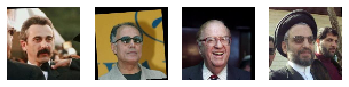

In [6]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

#### Define Model

In [7]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

#### Train Model

In [8]:
# define loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# define trainer (optimizer) for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [9]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,), ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                      nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
#     logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
#     logging.info('time: %f' % (time.time() - tic))

#     #Visualize one generated image for each epoch
#     fake_img = fake[0]
#     visualize(fake_img)
#     plt.show()

INFO:root:speed: 55.9815977506879 samples/s
INFO:root:discriminator loss = 1.565475, generator loss = 3.347895, binary training acc = 0.546875 at iter 0 epoch 0
INFO:root:speed: 746.2033330090205 samples/s
INFO:root:discriminator loss = 0.283865, generator loss = 8.997851, binary training acc = 0.894176 at iter 10 epoch 0
INFO:root:speed: 819.4475747982941 samples/s
INFO:root:discriminator loss = 0.062452, generator loss = 13.003567, binary training acc = 0.935640 at iter 20 epoch 0
INFO:root:speed: 819.4800957358472 samples/s
INFO:root:discriminator loss = 0.167297, generator loss = 8.611050, binary training acc = 0.917087 at iter 30 epoch 0
INFO:root:speed: 819.4050513128896 samples/s
INFO:root:discriminator loss = 0.443948, generator loss = 12.281281, binary training acc = 0.916540 at iter 40 epoch 0
INFO:root:speed: 746.1722195969423 samples/s
INFO:root:discriminator loss = 0.235708, generator loss = 7.115448, binary training acc = 0.911458 at iter 50 epoch 0
INFO:root:speed: 763.9

INFO:root:discriminator loss = 0.505142, generator loss = 4.325362, binary training acc = 0.857639 at iter 80 epoch 2
INFO:root:speed: 682.8090574714982 samples/s
INFO:root:discriminator loss = 0.600418, generator loss = 4.899508, binary training acc = 0.860834 at iter 90 epoch 2
INFO:root:speed: 682.8629036155918 samples/s
INFO:root:discriminator loss = 0.552922, generator loss = 5.362082, binary training acc = 0.867110 at iter 100 epoch 2
INFO:root:speed: 819.3775384681129 samples/s
INFO:root:discriminator loss = 1.130990, generator loss = 6.296556, binary training acc = 0.865639 at iter 110 epoch 2
INFO:root:speed: 819.3725363311977 samples/s
INFO:root:discriminator loss = 0.316646, generator loss = 5.290095, binary training acc = 0.865444 at iter 120 epoch 2
INFO:root:speed: 819.3975476265335 samples/s
INFO:root:discriminator loss = 0.449381, generator loss = 6.924245, binary training acc = 0.865637 at iter 130 epoch 2
INFO:root:speed: 682.8229524376409 samples/s
INFO:root:discrimi

INFO:root:speed: 737.3101512329911 samples/s
INFO:root:discriminator loss = 0.563144, generator loss = 3.040834, binary training acc = 0.883315 at iter 170 epoch 4
INFO:root:speed: 733.6988296261472 samples/s
INFO:root:discriminator loss = 0.288254, generator loss = 5.051580, binary training acc = 0.885359 at iter 180 epoch 4
INFO:root:speed: 729.2004465898626 samples/s
INFO:root:discriminator loss = 0.526984, generator loss = 4.454659, binary training acc = 0.884653 at iter 190 epoch 4
INFO:root:speed: 737.8674927638614 samples/s
INFO:root:discriminator loss = 0.217324, generator loss = 6.115750, binary training acc = 0.884134 at iter 200 epoch 4
INFO:root:speed: 729.2162938212243 samples/s
INFO:root:discriminator loss = 0.152889, generator loss = 4.263330, binary training acc = 0.984375 at iter 0 epoch 5
INFO:root:speed: 605.133614519485 samples/s
INFO:root:discriminator loss = 0.519382, generator loss = 6.092457, binary training acc = 0.913352 at iter 10 epoch 5
INFO:root:speed: 682

INFO:root:discriminator loss = 0.262086, generator loss = 5.153945, binary training acc = 0.895960 at iter 40 epoch 7
INFO:root:speed: 640.3670316562896 samples/s
INFO:root:discriminator loss = 0.194664, generator loss = 4.876037, binary training acc = 0.902727 at iter 50 epoch 7
INFO:root:speed: 682.8160048838806 samples/s
INFO:root:discriminator loss = 0.584413, generator loss = 4.302680, binary training acc = 0.905225 at iter 60 epoch 7
INFO:root:speed: 819.0325342413508 samples/s
INFO:root:discriminator loss = 0.247355, generator loss = 4.641167, binary training acc = 0.913402 at iter 70 epoch 7
INFO:root:speed: 683.055777216839 samples/s
INFO:root:discriminator loss = 0.210515, generator loss = 5.645682, binary training acc = 0.907890 at iter 80 epoch 7
INFO:root:speed: 808.5941116580015 samples/s
INFO:root:discriminator loss = 0.325962, generator loss = 5.868034, binary training acc = 0.907709 at iter 90 epoch 7
INFO:root:speed: 682.873326430881 samples/s
INFO:root:discriminator 

INFO:root:speed: 683.0401347579268 samples/s
INFO:root:discriminator loss = 0.460356, generator loss = 4.593535, binary training acc = 0.893368 at iter 130 epoch 9
INFO:root:speed: 682.8629036155918 samples/s
INFO:root:discriminator loss = 0.522588, generator loss = 9.528679, binary training acc = 0.890680 at iter 140 epoch 9
INFO:root:speed: 746.1867388663574 samples/s
INFO:root:discriminator loss = 0.377553, generator loss = 3.357384, binary training acc = 0.890263 at iter 150 epoch 9
INFO:root:speed: 741.5815258980543 samples/s
INFO:root:discriminator loss = 0.451744, generator loss = 5.216069, binary training acc = 0.891935 at iter 160 epoch 9
INFO:root:speed: 789.1818053530269 samples/s
INFO:root:discriminator loss = 0.307266, generator loss = 3.743819, binary training acc = 0.894189 at iter 170 epoch 9
INFO:root:speed: 728.9568820842588 samples/s
INFO:root:discriminator loss = 0.244705, generator loss = 4.031886, binary training acc = 0.896711 at iter 180 epoch 9
INFO:root:speed:

INFO:root:speed: 683.0696822262483 samples/s
INFO:root:discriminator loss = 0.380521, generator loss = 4.924522, binary training acc = 0.976562 at iter 0 epoch 12
INFO:root:speed: 736.6000027440489 samples/s
INFO:root:discriminator loss = 0.460232, generator loss = 4.436987, binary training acc = 0.903409 at iter 10 epoch 12
INFO:root:speed: 683.054039130468 samples/s
INFO:root:discriminator loss = 0.319106, generator loss = 5.319541, binary training acc = 0.910714 at iter 20 epoch 12
INFO:root:speed: 713.0176424651639 samples/s
INFO:root:discriminator loss = 0.169392, generator loss = 4.799626, binary training acc = 0.916079 at iter 30 epoch 12
INFO:root:speed: 737.6120244555884 samples/s
INFO:root:discriminator loss = 0.179694, generator loss = 4.387797, binary training acc = 0.925877 at iter 40 epoch 12
INFO:root:speed: 716.8812201394583 samples/s
INFO:root:discriminator loss = 0.344177, generator loss = 5.773140, binary training acc = 0.926011 at iter 50 epoch 12
INFO:root:speed: 7

INFO:root:speed: 721.025031090769 samples/s
INFO:root:discriminator loss = 0.362129, generator loss = 2.350611, binary training acc = 0.889275 at iter 80 epoch 14
INFO:root:speed: 656.1032419537758 samples/s
INFO:root:discriminator loss = 0.435615, generator loss = 4.556306, binary training acc = 0.892685 at iter 90 epoch 14
INFO:root:speed: 721.0308412168878 samples/s
INFO:root:discriminator loss = 0.234927, generator loss = 4.055048, binary training acc = 0.895730 at iter 100 epoch 14
INFO:root:speed: 713.0119607629601 samples/s
INFO:root:discriminator loss = 0.354572, generator loss = 4.549197, binary training acc = 0.901394 at iter 110 epoch 14
INFO:root:speed: 713.0138546536336 samples/s
INFO:root:discriminator loss = 0.436413, generator loss = 4.264916, binary training acc = 0.895661 at iter 120 epoch 14
INFO:root:speed: 704.950959331488 samples/s
INFO:root:discriminator loss = 0.626511, generator loss = 3.099069, binary training acc = 0.888418 at iter 130 epoch 14
INFO:root:spee

INFO:root:speed: 716.3780610175281 samples/s
INFO:root:discriminator loss = 0.712926, generator loss = 5.914409, binary training acc = 0.883201 at iter 160 epoch 16
INFO:root:speed: 666.2979576842503 samples/s
INFO:root:discriminator loss = 1.998373, generator loss = 0.381349, binary training acc = 0.880437 at iter 170 epoch 16
INFO:root:speed: 729.2162938212243 samples/s
INFO:root:discriminator loss = 0.444136, generator loss = 3.644205, binary training acc = 0.877029 at iter 180 epoch 16
INFO:root:speed: 748.4732938512843 samples/s
INFO:root:discriminator loss = 0.821422, generator loss = 2.757563, binary training acc = 0.872423 at iter 190 epoch 16
INFO:root:speed: 682.6007008193178 samples/s
INFO:root:discriminator loss = 0.386149, generator loss = 3.814508, binary training acc = 0.874417 at iter 200 epoch 16
INFO:root:speed: 765.5367346356766 samples/s
INFO:root:discriminator loss = 0.387326, generator loss = 4.884415, binary training acc = 0.968750 at iter 0 epoch 17
INFO:root:sp

INFO:root:speed: 796.2419496452386 samples/s
INFO:root:discriminator loss = 0.525486, generator loss = 3.438573, binary training acc = 0.849546 at iter 30 epoch 19
INFO:root:speed: 736.4908705302637 samples/s
INFO:root:discriminator loss = 0.349156, generator loss = 2.999918, binary training acc = 0.858232 at iter 40 epoch 19
INFO:root:speed: 627.0830845422478 samples/s
INFO:root:discriminator loss = 0.374654, generator loss = 3.633123, binary training acc = 0.858609 at iter 50 epoch 19
INFO:root:speed: 788.0350047998028 samples/s
INFO:root:discriminator loss = 0.446088, generator loss = 3.752121, binary training acc = 0.851178 at iter 60 epoch 19
INFO:root:speed: 672.4671977553986 samples/s
INFO:root:discriminator loss = 1.163691, generator loss = 1.675686, binary training acc = 0.855524 at iter 70 epoch 19
INFO:root:speed: 713.019536386021 samples/s
INFO:root:discriminator loss = 0.269205, generator loss = 2.795824, binary training acc = 0.850694 at iter 80 epoch 19
INFO:root:speed: 

INFO:root:speed: 705.1805959092318 samples/s
INFO:root:discriminator loss = 0.238945, generator loss = 4.106256, binary training acc = 0.861346 at iter 110 epoch 21
INFO:root:speed: 849.9015523535428 samples/s
INFO:root:discriminator loss = 0.574275, generator loss = 4.385955, binary training acc = 0.862539 at iter 120 epoch 21
INFO:root:speed: 785.4892594727617 samples/s
INFO:root:discriminator loss = 0.375394, generator loss = 2.551345, binary training acc = 0.865398 at iter 130 epoch 21
INFO:root:speed: 706.4035178669642 samples/s
INFO:root:discriminator loss = 0.417860, generator loss = 3.400691, binary training acc = 0.866689 at iter 140 epoch 21
INFO:root:speed: 683.1096622820077 samples/s
INFO:root:discriminator loss = 1.109855, generator loss = 6.429409, binary training acc = 0.861910 at iter 150 epoch 21
INFO:root:speed: 749.3466582548447 samples/s
INFO:root:discriminator loss = 0.994435, generator loss = 5.068285, binary training acc = 0.851029 at iter 160 epoch 21
INFO:root:

INFO:root:speed: 682.8333740333741 samples/s
INFO:root:discriminator loss = 0.281658, generator loss = 3.858162, binary training acc = 0.856062 at iter 190 epoch 23
INFO:root:speed: 765.0654551880205 samples/s
INFO:root:discriminator loss = 0.390810, generator loss = 3.790480, binary training acc = 0.859492 at iter 200 epoch 23
INFO:root:speed: 682.9237078571647 samples/s
INFO:root:discriminator loss = 0.264906, generator loss = 4.264408, binary training acc = 0.968750 at iter 0 epoch 24
INFO:root:speed: 713.0422642211096 samples/s
INFO:root:discriminator loss = 0.522256, generator loss = 3.226679, binary training acc = 0.787642 at iter 10 epoch 24
INFO:root:speed: 721.2846414071254 samples/s
INFO:root:discriminator loss = 0.373516, generator loss = 2.924346, binary training acc = 0.851562 at iter 20 epoch 24
INFO:root:speed: 686.0864906864048 samples/s
INFO:root:discriminator loss = 0.293067, generator loss = 4.479494, binary training acc = 0.872984 at iter 30 epoch 24
INFO:root:speed

INFO:root:speed: 682.9428199981173 samples/s
INFO:root:discriminator loss = 0.666782, generator loss = 2.739557, binary training acc = 0.785989 at iter 60 epoch 26
INFO:root:speed: 682.8403219405977 samples/s
INFO:root:discriminator loss = 0.595591, generator loss = 3.026119, binary training acc = 0.806778 at iter 70 epoch 26
INFO:root:speed: 683.0349207641652 samples/s
INFO:root:discriminator loss = 0.515535, generator loss = 2.989160, binary training acc = 0.804205 at iter 80 epoch 26
INFO:root:speed: 677.0551888517562 samples/s
INFO:root:discriminator loss = 0.738319, generator loss = 5.170931, binary training acc = 0.813359 at iter 90 epoch 26
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 1.146542, generator loss = 1.745579, binary training acc = 0.817992 at iter 100 epoch 26
INFO:root:speed: 682.8194786430882 samples/s
INFO:root:discriminator loss = 0.350093, generator loss = 2.700678, binary training acc = 0.828125 at iter 110 epoch 26
INFO:root:spee

INFO:root:speed: 725.9289419171296 samples/s
INFO:root:discriminator loss = 0.869657, generator loss = 5.246137, binary training acc = 0.855219 at iter 140 epoch 28
INFO:root:speed: 682.8021102004894 samples/s
INFO:root:discriminator loss = 0.557527, generator loss = 2.962046, binary training acc = 0.855132 at iter 150 epoch 28
INFO:root:speed: 819.382540666103 samples/s
INFO:root:discriminator loss = 0.358448, generator loss = 2.436997, binary training acc = 0.856318 at iter 160 epoch 28
INFO:root:speed: 682.6128514648555 samples/s
INFO:root:discriminator loss = 0.252191, generator loss = 4.054816, binary training acc = 0.860380 at iter 170 epoch 28
INFO:root:speed: 682.8246893481717 samples/s
INFO:root:discriminator loss = 0.408651, generator loss = 3.313691, binary training acc = 0.860368 at iter 180 epoch 28
INFO:root:speed: 712.7639480420168 samples/s
INFO:root:discriminator loss = 0.588552, generator loss = 2.751362, binary training acc = 0.860193 at iter 190 epoch 28
INFO:root:s

INFO:root:speed: 656.1914535263187 samples/s
INFO:root:discriminator loss = 0.410272, generator loss = 3.019471, binary training acc = 0.936080 at iter 10 epoch 31
INFO:root:speed: 682.5868148969389 samples/s
INFO:root:discriminator loss = 0.286336, generator loss = 4.220069, binary training acc = 0.910342 at iter 20 epoch 31
INFO:root:speed: 682.803847004988 samples/s
INFO:root:discriminator loss = 0.933098, generator loss = 6.635445, binary training acc = 0.886845 at iter 30 epoch 31
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 0.845435, generator loss = 3.949164, binary training acc = 0.822409 at iter 40 epoch 31
INFO:root:speed: 819.4375688752538 samples/s
INFO:root:discriminator loss = 0.591052, generator loss = 4.768708, binary training acc = 0.824755 at iter 50 epoch 31
INFO:root:speed: 682.8246893481717 samples/s
INFO:root:discriminator loss = 0.573716, generator loss = 2.311205, binary training acc = 0.830046 at iter 60 epoch 31
INFO:root:speed: 

INFO:root:speed: 682.8542181792282 samples/s
INFO:root:discriminator loss = 0.310325, generator loss = 3.006177, binary training acc = 0.902558 at iter 90 epoch 33
INFO:root:speed: 682.803847004988 samples/s
INFO:root:discriminator loss = 0.583409, generator loss = 3.091685, binary training acc = 0.904935 at iter 100 epoch 33
INFO:root:speed: 818.9800590661688 samples/s
INFO:root:discriminator loss = 0.323014, generator loss = 3.404506, binary training acc = 0.906180 at iter 110 epoch 33
INFO:root:speed: 639.6849086234055 samples/s
INFO:root:discriminator loss = 0.603342, generator loss = 4.617908, binary training acc = 0.906185 at iter 120 epoch 33
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 0.448896, generator loss = 2.720530, binary training acc = 0.908516 at iter 130 epoch 33
INFO:root:speed: 682.8212155359464 samples/s
INFO:root:discriminator loss = 0.587836, generator loss = 1.060487, binary training acc = 0.905530 at iter 140 epoch 33
INFO:root:sp

INFO:root:speed: 819.4200590979023 samples/s
INFO:root:discriminator loss = 0.485322, generator loss = 4.478061, binary training acc = 0.889391 at iter 170 epoch 35
INFO:root:speed: 705.141695321304 samples/s
INFO:root:discriminator loss = 0.342109, generator loss = 3.185314, binary training acc = 0.888294 at iter 180 epoch 35
INFO:root:speed: 682.859429414533 samples/s
INFO:root:discriminator loss = 0.513975, generator loss = 2.606297, binary training acc = 0.887844 at iter 190 epoch 35
INFO:root:speed: 682.8333740333741 samples/s
INFO:root:discriminator loss = 0.500539, generator loss = 5.124656, binary training acc = 0.891325 at iter 200 epoch 35
INFO:root:speed: 643.8675304801264 samples/s
INFO:root:discriminator loss = 0.238551, generator loss = 3.384473, binary training acc = 0.984375 at iter 0 epoch 36
INFO:root:speed: 682.8316370786603 samples/s
INFO:root:discriminator loss = 0.765527, generator loss = 2.006374, binary training acc = 0.896307 at iter 10 epoch 36
INFO:root:speed

INFO:root:speed: 682.8107943113399 samples/s
INFO:root:discriminator loss = 0.720870, generator loss = 2.460929, binary training acc = 0.945884 at iter 40 epoch 38
INFO:root:speed: 737.6099976368822 samples/s
INFO:root:discriminator loss = 0.749359, generator loss = 2.233999, binary training acc = 0.939491 at iter 50 epoch 38
INFO:root:speed: 697.5139562318434 samples/s
INFO:root:discriminator loss = 0.418329, generator loss = 4.169588, binary training acc = 0.930584 at iter 60 epoch 38
INFO:root:speed: 713.275308097422 samples/s
INFO:root:discriminator loss = 0.369361, generator loss = 1.931695, binary training acc = 0.934419 at iter 70 epoch 38
INFO:root:speed: 721.0076012742206 samples/s
INFO:root:discriminator loss = 0.353920, generator loss = 3.444929, binary training acc = 0.931617 at iter 80 epoch 38
INFO:root:speed: 745.1221100492148 samples/s
INFO:root:discriminator loss = 0.402377, generator loss = 3.774776, binary training acc = 0.923935 at iter 90 epoch 38
INFO:root:speed: 

INFO:root:speed: 819.3975476265335 samples/s
INFO:root:discriminator loss = 0.275914, generator loss = 3.973222, binary training acc = 0.905217 at iter 120 epoch 40
INFO:root:speed: 713.2544605729196 samples/s
INFO:root:discriminator loss = 0.408988, generator loss = 2.946913, binary training acc = 0.908516 at iter 130 epoch 40
INFO:root:speed: 682.8472699892143 samples/s
INFO:root:discriminator loss = 0.194641, generator loss = 4.414442, binary training acc = 0.913010 at iter 140 epoch 40
INFO:root:speed: 614.5739554881943 samples/s
INFO:root:discriminator loss = 0.451526, generator loss = 3.296248, binary training acc = 0.914787 at iter 150 epoch 40
INFO:root:speed: 720.9998549595767 samples/s
INFO:root:discriminator loss = 0.350217, generator loss = 3.205037, binary training acc = 0.917120 at iter 160 epoch 40
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 0.236799, generator loss = 3.283032, binary training acc = 0.918860 at iter 170 epoch 40
INFO:root:

INFO:root:speed: 721.3893133463582 samples/s
INFO:root:discriminator loss = 0.230794, generator loss = 4.720119, binary training acc = 0.893579 at iter 200 epoch 42
INFO:root:speed: 765.1788583123821 samples/s
INFO:root:discriminator loss = 0.251877, generator loss = 3.843946, binary training acc = 1.000000 at iter 0 epoch 43
INFO:root:speed: 667.1988705844924 samples/s
INFO:root:discriminator loss = 0.758711, generator loss = 1.510893, binary training acc = 0.884233 at iter 10 epoch 43
INFO:root:speed: 755.6070686655895 samples/s
INFO:root:discriminator loss = 2.035026, generator loss = 0.306506, binary training acc = 0.867932 at iter 20 epoch 43
INFO:root:speed: 674.4795861192143 samples/s
INFO:root:discriminator loss = 0.505482, generator loss = 4.761921, binary training acc = 0.867188 at iter 30 epoch 43
INFO:root:speed: 762.3170240620678 samples/s
INFO:root:discriminator loss = 0.184935, generator loss = 4.383338, binary training acc = 0.880145 at iter 40 epoch 43
INFO:root:speed:

INFO:root:speed: 617.9168914875006 samples/s
INFO:root:discriminator loss = 0.214707, generator loss = 2.578220, binary training acc = 0.935189 at iter 70 epoch 45
INFO:root:speed: 706.9318522381024 samples/s
INFO:root:discriminator loss = 0.597386, generator loss = 2.867285, binary training acc = 0.921971 at iter 80 epoch 45
INFO:root:speed: 705.1731859425323 samples/s
INFO:root:discriminator loss = 0.285147, generator loss = 3.362953, binary training acc = 0.925223 at iter 90 epoch 45
INFO:root:speed: 666.9999304264857 samples/s
INFO:root:discriminator loss = 0.266446, generator loss = 3.307943, binary training acc = 0.928450 at iter 100 epoch 45
INFO:root:speed: 682.7569563846131 samples/s
INFO:root:discriminator loss = 0.184982, generator loss = 4.092477, binary training acc = 0.933207 at iter 110 epoch 45
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 0.422461, generator loss = 4.675413, binary training acc = 0.933949 at iter 120 epoch 45
INFO:root:spe

INFO:root:speed: 819.3100147724914 samples/s
INFO:root:discriminator loss = 0.329127, generator loss = 4.354748, binary training acc = 0.902525 at iter 150 epoch 47
INFO:root:speed: 682.9567204089058 samples/s
INFO:root:discriminator loss = 0.688379, generator loss = 2.218977, binary training acc = 0.902562 at iter 160 epoch 47
INFO:root:speed: 682.8646407293782 samples/s
INFO:root:discriminator loss = 0.235574, generator loss = 3.200608, binary training acc = 0.905382 at iter 170 epoch 47
INFO:root:speed: 682.8507440665462 samples/s
INFO:root:discriminator loss = 0.249631, generator loss = 3.224727, binary training acc = 0.905128 at iter 180 epoch 47
INFO:root:speed: 609.9807667836172 samples/s
INFO:root:discriminator loss = 0.498623, generator loss = 5.682755, binary training acc = 0.907763 at iter 190 epoch 47
INFO:root:speed: 682.6527780603421 samples/s
INFO:root:discriminator loss = 0.189240, generator loss = 3.357088, binary training acc = 0.911186 at iter 200 epoch 47
INFO:root:

INFO:root:speed: 705.0139093163003 samples/s
INFO:root:discriminator loss = 0.115885, generator loss = 4.269174, binary training acc = 0.984375 at iter 20 epoch 50
INFO:root:speed: 726.4436458107815 samples/s
INFO:root:discriminator loss = 0.372984, generator loss = 5.796387, binary training acc = 0.981099 at iter 30 epoch 50
INFO:root:speed: 713.197609881424 samples/s
INFO:root:discriminator loss = 0.257432, generator loss = 3.601922, binary training acc = 0.973704 at iter 40 epoch 50
INFO:root:speed: 718.7585006600244 samples/s
INFO:root:discriminator loss = 0.419079, generator loss = 6.510269, binary training acc = 0.968903 at iter 50 epoch 50
INFO:root:speed: 712.9494680144696 samples/s
INFO:root:discriminator loss = 0.240037, generator loss = 3.956316, binary training acc = 0.963883 at iter 60 epoch 50
INFO:root:speed: 697.5121437870115 samples/s
INFO:root:discriminator loss = 0.156875, generator loss = 3.690077, binary training acc = 0.967870 at iter 70 epoch 50
INFO:root:speed: 

INFO:root:speed: 819.3725363311977 samples/s
INFO:root:discriminator loss = 0.315275, generator loss = 3.030337, binary training acc = 0.956915 at iter 100 epoch 52
INFO:root:speed: 682.836847969312 samples/s
INFO:root:discriminator loss = 0.290002, generator loss = 5.478908, binary training acc = 0.958263 at iter 110 epoch 52
INFO:root:speed: 721.0889476285647 samples/s
INFO:root:discriminator loss = 0.981550, generator loss = 8.684285, binary training acc = 0.957257 at iter 120 epoch 52
INFO:root:speed: 682.770849230331 samples/s
INFO:root:discriminator loss = 0.260909, generator loss = 2.914175, binary training acc = 0.954914 at iter 130 epoch 52
INFO:root:speed: 682.685764423138 samples/s
INFO:root:discriminator loss = 0.152036, generator loss = 4.267602, binary training acc = 0.956782 at iter 140 epoch 52
INFO:root:speed: 682.8872240128826 samples/s
INFO:root:discriminator loss = 0.074284, generator loss = 5.000224, binary training acc = 0.958454 at iter 150 epoch 52
INFO:root:spe

INFO:root:speed: 682.70833587662 samples/s
INFO:root:discriminator loss = 0.210151, generator loss = 4.213005, binary training acc = 0.982605 at iter 180 epoch 54
INFO:root:speed: 682.7743225301027 samples/s
INFO:root:discriminator loss = 1.553167, generator loss = 7.049408, binary training acc = 0.965969 at iter 190 epoch 54
INFO:root:speed: 713.0915128347488 samples/s
INFO:root:discriminator loss = 0.430140, generator loss = 5.298189, binary training acc = 0.958256 at iter 200 epoch 54
INFO:root:speed: 720.9785534525315 samples/s
INFO:root:discriminator loss = 0.364410, generator loss = 5.048462, binary training acc = 0.968750 at iter 0 epoch 55
INFO:root:speed: 683.0036384731643 samples/s
INFO:root:discriminator loss = 0.485273, generator loss = 6.386033, binary training acc = 0.951705 at iter 10 epoch 55
INFO:root:speed: 713.0612051905274 samples/s
INFO:root:discriminator loss = 0.383503, generator loss = 2.071918, binary training acc = 0.956473 at iter 20 epoch 55
INFO:root:speed:

INFO:root:speed: 682.7673759658967 samples/s
INFO:root:discriminator loss = 0.094641, generator loss = 4.198718, binary training acc = 0.992034 at iter 50 epoch 57
INFO:root:speed: 682.8524811184684 samples/s
INFO:root:discriminator loss = 0.124017, generator loss = 3.414488, binary training acc = 0.992828 at iter 60 epoch 57
INFO:root:speed: 682.6284743590396 samples/s
INFO:root:discriminator loss = 0.111950, generator loss = 4.460712, binary training acc = 0.992738 at iter 70 epoch 57
INFO:root:speed: 819.5351370494526 samples/s
INFO:root:discriminator loss = 1.325275, generator loss = 0.816151, binary training acc = 0.957272 at iter 80 epoch 57
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.683656, generator loss = 3.324281, binary training acc = 0.932005 at iter 90 epoch 57
INFO:root:speed: 729.3232806518484 samples/s
INFO:root:discriminator loss = 0.480797, generator loss = 2.558007, binary training acc = 0.918549 at iter 100 epoch 57
INFO:root:speed:

INFO:root:speed: 713.1104564207327 samples/s
INFO:root:discriminator loss = 0.176671, generator loss = 3.929983, binary training acc = 0.988251 at iter 130 epoch 59
INFO:root:speed: 729.0261724934888 samples/s
INFO:root:discriminator loss = 0.132612, generator loss = 4.240253, binary training acc = 0.988697 at iter 140 epoch 59
INFO:root:speed: 720.8798083636793 samples/s
INFO:root:discriminator loss = 0.128965, generator loss = 4.146012, binary training acc = 0.988255 at iter 150 epoch 59
INFO:root:speed: 582.6496988376762 samples/s
INFO:root:discriminator loss = 0.188905, generator loss = 2.692382, binary training acc = 0.988597 at iter 160 epoch 59
INFO:root:speed: 731.8285828010283 samples/s
INFO:root:discriminator loss = 0.090319, generator loss = 4.611406, binary training acc = 0.988670 at iter 170 epoch 59
INFO:root:speed: 713.4383398537166 samples/s
INFO:root:discriminator loss = 0.151330, generator loss = 4.600780, binary training acc = 0.988691 at iter 180 epoch 59
INFO:root:

INFO:root:speed: 682.6232666481877 samples/s
INFO:root:discriminator loss = 0.099454, generator loss = 3.483759, binary training acc = 1.000000 at iter 0 epoch 62
INFO:root:speed: 703.7902541595222 samples/s
INFO:root:discriminator loss = 0.185886, generator loss = 4.807179, binary training acc = 0.934659 at iter 10 epoch 62
INFO:root:speed: 710.4662308445597 samples/s
INFO:root:discriminator loss = 0.127988, generator loss = 4.331455, binary training acc = 0.958705 at iter 20 epoch 62
INFO:root:speed: 720.9843628296242 samples/s
INFO:root:discriminator loss = 0.183359, generator loss = 3.416142, binary training acc = 0.971018 at iter 30 epoch 62
INFO:root:speed: 712.8680545043645 samples/s
INFO:root:discriminator loss = 0.199300, generator loss = 5.509545, binary training acc = 0.976944 at iter 40 epoch 62
INFO:root:speed: 673.0961492651834 samples/s
INFO:root:discriminator loss = 0.249566, generator loss = 4.937760, binary training acc = 0.977788 at iter 50 epoch 62
INFO:root:speed: 

INFO:root:speed: 755.9134700406066 samples/s
INFO:root:discriminator loss = 0.257569, generator loss = 6.277928, binary training acc = 0.972029 at iter 80 epoch 64
INFO:root:speed: 721.0114744939619 samples/s
INFO:root:discriminator loss = 0.183423, generator loss = 3.419148, binary training acc = 0.972184 at iter 90 epoch 64
INFO:root:speed: 755.5283806414388 samples/s
INFO:root:discriminator loss = 0.199933, generator loss = 4.603945, binary training acc = 0.974397 at iter 100 epoch 64
INFO:root:speed: 782.3529158032485 samples/s
INFO:root:discriminator loss = 0.070869, generator loss = 4.739679, binary training acc = 0.975436 at iter 110 epoch 64
INFO:root:speed: 721.0889476285647 samples/s
INFO:root:discriminator loss = 0.247698, generator loss = 2.389020, binary training acc = 0.976885 at iter 120 epoch 64
INFO:root:speed: 638.0124781038986 samples/s
INFO:root:discriminator loss = 0.100421, generator loss = 3.975180, binary training acc = 0.976980 at iter 130 epoch 64
INFO:root:sp

INFO:root:speed: 819.3350222509813 samples/s
INFO:root:discriminator loss = 0.102358, generator loss = 3.370910, binary training acc = 0.977776 at iter 160 epoch 66
INFO:root:speed: 682.5954935322194 samples/s
INFO:root:discriminator loss = 0.103061, generator loss = 4.647186, binary training acc = 0.978664 at iter 170 epoch 66
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 0.136241, generator loss = 4.123470, binary training acc = 0.979713 at iter 180 epoch 66
INFO:root:speed: 682.8281631957428 samples/s
INFO:root:discriminator loss = 0.104886, generator loss = 4.831388, binary training acc = 0.980776 at iter 190 epoch 66
INFO:root:speed: 707.6754613518929 samples/s
INFO:root:discriminator loss = 0.080132, generator loss = 4.263103, binary training acc = 0.981304 at iter 200 epoch 66
INFO:root:speed: 682.5850791963647 samples/s
INFO:root:discriminator loss = 0.099348, generator loss = 4.740439, binary training acc = 0.992188 at iter 0 epoch 67
INFO:root:sp

INFO:root:speed: 683.0349207641652 samples/s
INFO:root:discriminator loss = 0.230240, generator loss = 3.463313, binary training acc = 0.975050 at iter 30 epoch 69
INFO:root:speed: 729.2162938212243 samples/s
INFO:root:discriminator loss = 0.130622, generator loss = 4.663813, binary training acc = 0.978468 at iter 40 epoch 69
INFO:root:speed: 728.4148920004342 samples/s
INFO:root:discriminator loss = 0.150587, generator loss = 4.298556, binary training acc = 0.978707 at iter 50 epoch 69
INFO:root:speed: 682.7309088226991 samples/s
INFO:root:discriminator loss = 0.220376, generator loss = 3.340420, binary training acc = 0.980661 at iter 60 epoch 69
INFO:root:speed: 682.8246893481717 samples/s
INFO:root:discriminator loss = 0.146903, generator loss = 4.013321, binary training acc = 0.982724 at iter 70 epoch 69
INFO:root:speed: 646.9134831352362 samples/s
INFO:root:discriminator loss = 0.112706, generator loss = 3.923347, binary training acc = 0.984375 at iter 80 epoch 69
INFO:root:speed:

INFO:root:speed: 682.8021102004894 samples/s
INFO:root:discriminator loss = 5.816247, generator loss = 9.027453, binary training acc = 0.987401 at iter 110 epoch 71
INFO:root:speed: 819.722833472277 samples/s
INFO:root:discriminator loss = 0.935976, generator loss = 1.592304, binary training acc = 0.962423 at iter 120 epoch 71
INFO:root:speed: 682.9688837325273 samples/s
INFO:root:discriminator loss = 0.358103, generator loss = 4.292560, binary training acc = 0.947698 at iter 130 epoch 71
INFO:root:speed: 819.3800395594735 samples/s
INFO:root:discriminator loss = 0.162464, generator loss = 5.893311, binary training acc = 0.945146 at iter 140 epoch 71
INFO:root:speed: 819.4850991861182 samples/s
INFO:root:discriminator loss = 0.208605, generator loss = 6.238064, binary training acc = 0.943502 at iter 150 epoch 71
INFO:root:speed: 737.4681480016264 samples/s
INFO:root:discriminator loss = 0.216655, generator loss = 4.077707, binary training acc = 0.943420 at iter 160 epoch 71
INFO:root:s

INFO:root:speed: 682.6510420242863 samples/s
INFO:root:discriminator loss = 0.135400, generator loss = 5.657407, binary training acc = 0.984620 at iter 190 epoch 73
INFO:root:speed: 721.025031090769 samples/s
INFO:root:discriminator loss = 0.138524, generator loss = 4.693476, binary training acc = 0.984103 at iter 200 epoch 73
INFO:root:speed: 720.9475716890881 samples/s
INFO:root:discriminator loss = 0.069599, generator loss = 4.813047, binary training acc = 1.000000 at iter 0 epoch 74
INFO:root:speed: 682.7968998400065 samples/s
INFO:root:discriminator loss = 0.145699, generator loss = 4.710219, binary training acc = 0.997159 at iter 10 epoch 74
INFO:root:speed: 682.7378546448782 samples/s
INFO:root:discriminator loss = 0.121311, generator loss = 4.187949, binary training acc = 0.997396 at iter 20 epoch 74
INFO:root:speed: 819.3900440776059 samples/s
INFO:root:discriminator loss = 0.131258, generator loss = 4.797722, binary training acc = 0.998236 at iter 30 epoch 74
INFO:root:speed:

INFO:root:speed: 756.3671446403363 samples/s
INFO:root:discriminator loss = 0.082417, generator loss = 5.399857, binary training acc = 0.999488 at iter 60 epoch 76
INFO:root:speed: 756.3522264924994 samples/s
INFO:root:discriminator loss = 0.060027, generator loss = 4.798526, binary training acc = 0.999560 at iter 70 epoch 76
INFO:root:speed: 713.0062791513052 samples/s
INFO:root:discriminator loss = 0.051526, generator loss = 5.593028, binary training acc = 0.999614 at iter 80 epoch 76
INFO:root:speed: 713.008173011796 samples/s
INFO:root:discriminator loss = 0.041778, generator loss = 4.602986, binary training acc = 0.999571 at iter 90 epoch 76
INFO:root:speed: 756.0071422536402 samples/s
INFO:root:discriminator loss = 0.048123, generator loss = 5.187389, binary training acc = 0.999613 at iter 100 epoch 76
INFO:root:speed: 721.015347755317 samples/s
INFO:root:discriminator loss = 0.053131, generator loss = 5.574630, binary training acc = 0.999648 at iter 110 epoch 76
INFO:root:speed:

INFO:root:speed: 819.4300645933306 samples/s
INFO:root:discriminator loss = 0.181055, generator loss = 3.794474, binary training acc = 0.967808 at iter 140 epoch 78
INFO:root:speed: 819.7278398871343 samples/s
INFO:root:discriminator loss = 0.110487, generator loss = 3.968197, binary training acc = 0.969733 at iter 150 epoch 78
INFO:root:speed: 729.2143128796357 samples/s
INFO:root:discriminator loss = 0.226882, generator loss = 2.804685, binary training acc = 0.971128 at iter 160 epoch 78
INFO:root:speed: 682.7604295430382 samples/s
INFO:root:discriminator loss = 0.102356, generator loss = 3.880014, binary training acc = 0.972405 at iter 170 epoch 78
INFO:root:speed: 683.0001628399284 samples/s
INFO:root:discriminator loss = 0.140102, generator loss = 4.159216, binary training acc = 0.973368 at iter 180 epoch 78
INFO:root:speed: 819.4775940336234 samples/s
INFO:root:discriminator loss = 0.089875, generator loss = 4.694842, binary training acc = 0.974231 at iter 190 epoch 78
INFO:root:

INFO:root:speed: 729.2222367105663 samples/s
INFO:root:discriminator loss = 0.090537, generator loss = 4.971179, binary training acc = 1.000000 at iter 10 epoch 81
INFO:root:speed: 720.8372207930311 samples/s
INFO:root:discriminator loss = 0.084975, generator loss = 4.810996, binary training acc = 1.000000 at iter 20 epoch 81
INFO:root:speed: 682.6510420242863 samples/s
INFO:root:discriminator loss = 0.074539, generator loss = 4.424172, binary training acc = 0.999748 at iter 30 epoch 81
INFO:root:speed: 682.7517467132287 samples/s
INFO:root:discriminator loss = 0.093273, generator loss = 5.438034, binary training acc = 0.999809 at iter 40 epoch 81
INFO:root:speed: 682.8333740333741 samples/s
INFO:root:discriminator loss = 0.059334, generator loss = 4.390627, binary training acc = 0.999847 at iter 50 epoch 81
INFO:root:speed: 819.5276309804029 samples/s
INFO:root:discriminator loss = 0.073582, generator loss = 5.080024, binary training acc = 0.999872 at iter 60 epoch 81
INFO:root:speed:

INFO:root:speed: 819.7128208260173 samples/s
INFO:root:discriminator loss = 0.049299, generator loss = 5.010592, binary training acc = 0.998283 at iter 90 epoch 83
INFO:root:speed: 713.0706760525966 samples/s
INFO:root:discriminator loss = 1.361873, generator loss = 1.694028, binary training acc = 0.966043 at iter 100 epoch 83
INFO:root:speed: 721.0289044977773 samples/s
INFO:root:discriminator loss = 1.228684, generator loss = 4.840608, binary training acc = 0.938978 at iter 110 epoch 83
INFO:root:speed: 682.7604295430382 samples/s
INFO:root:discriminator loss = 0.662996, generator loss = 2.880293, binary training acc = 0.922133 at iter 120 epoch 83
INFO:root:speed: 682.8333740333741 samples/s
INFO:root:discriminator loss = 0.508570, generator loss = 4.986314, binary training acc = 0.914182 at iter 130 epoch 83
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.437453, generator loss = 5.376709, binary training acc = 0.911070 at iter 140 epoch 83
INFO:root:sp

INFO:root:speed: 682.8316370786603 samples/s
INFO:root:discriminator loss = 0.079447, generator loss = 4.166765, binary training acc = 0.994609 at iter 170 epoch 85
INFO:root:speed: 682.8333740333741 samples/s
INFO:root:discriminator loss = 0.080526, generator loss = 4.036749, binary training acc = 0.994820 at iter 180 epoch 85
INFO:root:speed: 682.8281631957428 samples/s
INFO:root:discriminator loss = 0.068598, generator loss = 4.671948, binary training acc = 0.995092 at iter 190 epoch 85
INFO:root:speed: 759.3905762006066 samples/s
INFO:root:discriminator loss = 0.053710, generator loss = 5.596084, binary training acc = 0.995297 at iter 200 epoch 85
INFO:root:speed: 609.0148059078431 samples/s
INFO:root:discriminator loss = 0.041240, generator loss = 5.236114, binary training acc = 1.000000 at iter 0 epoch 86
INFO:root:speed: 626.3091047809257 samples/s
INFO:root:discriminator loss = 0.088189, generator loss = 4.908475, binary training acc = 1.000000 at iter 10 epoch 86
INFO:root:spe

INFO:root:speed: 638.2840321667879 samples/s
INFO:root:discriminator loss = 0.725233, generator loss = 2.283833, binary training acc = 0.859947 at iter 40 epoch 88
INFO:root:speed: 756.6570997702704 samples/s
INFO:root:discriminator loss = 1.553265, generator loss = 1.900783, binary training acc = 0.857537 at iter 50 epoch 88
INFO:root:speed: 721.0037280960925 samples/s
INFO:root:discriminator loss = 0.606157, generator loss = 2.770227, binary training acc = 0.867316 at iter 60 epoch 88
INFO:root:speed: 720.9456354172821 samples/s
INFO:root:discriminator loss = 0.842159, generator loss = 5.470745, binary training acc = 0.870929 at iter 70 epoch 88
INFO:root:speed: 727.1441852401642 samples/s
INFO:root:discriminator loss = 0.317553, generator loss = 3.508402, binary training acc = 0.876543 at iter 80 epoch 88
INFO:root:speed: 756.3756695604641 samples/s
INFO:root:discriminator loss = 0.209783, generator loss = 4.614440, binary training acc = 0.886590 at iter 90 epoch 88
INFO:root:speed:

INFO:root:speed: 721.026967789071 samples/s
INFO:root:discriminator loss = 0.042004, generator loss = 4.782760, binary training acc = 0.998902 at iter 120 epoch 90
INFO:root:speed: 682.6579862214887 samples/s
INFO:root:discriminator loss = 0.034326, generator loss = 5.430686, binary training acc = 0.998927 at iter 130 epoch 90
INFO:root:speed: 678.8890754772334 samples/s
INFO:root:discriminator loss = 0.047997, generator loss = 4.476591, binary training acc = 0.998947 at iter 140 epoch 90
INFO:root:speed: 682.8194786430882 samples/s
INFO:root:discriminator loss = 0.089766, generator loss = 3.948600, binary training acc = 0.999017 at iter 150 epoch 90
INFO:root:speed: 682.8003734048262 samples/s
INFO:root:discriminator loss = 0.082174, generator loss = 4.470543, binary training acc = 0.999030 at iter 160 epoch 90
INFO:root:speed: 683.0019006521247 samples/s
INFO:root:discriminator loss = 0.061632, generator loss = 4.972679, binary training acc = 0.999086 at iter 170 epoch 90
INFO:root:s

INFO:root:speed: 680.5223815137341 samples/s
INFO:root:discriminator loss = 1.988404, generator loss = 1.407217, binary training acc = 0.910487 at iter 200 epoch 92
INFO:root:speed: 712.115387778382 samples/s
INFO:root:discriminator loss = 0.838963, generator loss = 1.835512, binary training acc = 0.796875 at iter 0 epoch 93
INFO:root:speed: 819.3925452453121 samples/s
INFO:root:discriminator loss = 1.030393, generator loss = 7.888282, binary training acc = 0.775568 at iter 10 epoch 93
INFO:root:speed: 711.14004747372 samples/s
INFO:root:discriminator loss = 0.619757, generator loss = 7.407637, binary training acc = 0.805432 at iter 20 epoch 93
INFO:root:speed: 713.197609881424 samples/s
INFO:root:discriminator loss = 0.638504, generator loss = 7.042324, binary training acc = 0.821573 at iter 30 epoch 93
INFO:root:speed: 683.2852822888561 samples/s
INFO:root:discriminator loss = 0.518881, generator loss = 7.947969, binary training acc = 0.844512 at iter 40 epoch 93
INFO:root:speed: 705

INFO:root:speed: 819.7203302877804 samples/s
INFO:root:discriminator loss = 0.079158, generator loss = 4.599315, binary training acc = 0.998460 at iter 70 epoch 95
INFO:root:speed: 682.789952816391 samples/s
INFO:root:discriminator loss = 0.063677, generator loss = 5.027682, binary training acc = 0.998650 at iter 80 epoch 95
INFO:root:speed: 682.6579862214887 samples/s
INFO:root:discriminator loss = 0.048219, generator loss = 5.143914, binary training acc = 0.998712 at iter 90 epoch 95
INFO:root:speed: 819.3550293329426 samples/s
INFO:root:discriminator loss = 0.082908, generator loss = 5.537049, binary training acc = 0.998685 at iter 100 epoch 95
INFO:root:speed: 682.6527780603421 samples/s
INFO:root:discriminator loss = 0.049681, generator loss = 5.204693, binary training acc = 0.998803 at iter 110 epoch 95
INFO:root:speed: 683.0696822262483 samples/s
INFO:root:discriminator loss = 0.064786, generator loss = 4.646667, binary training acc = 0.998902 at iter 120 epoch 95
INFO:root:spee

INFO:root:speed: 721.038588197373 samples/s
INFO:root:discriminator loss = 0.158565, generator loss = 5.485738, binary training acc = 0.916080 at iter 150 epoch 97
INFO:root:speed: 682.746537121347 samples/s
INFO:root:discriminator loss = 0.354446, generator loss = 2.054935, binary training acc = 0.919983 at iter 160 epoch 97
INFO:root:speed: 713.0252182089599 samples/s
INFO:root:discriminator loss = 0.106584, generator loss = 5.255582, binary training acc = 0.923246 at iter 170 epoch 97
INFO:root:speed: 819.4625841410364 samples/s
INFO:root:discriminator loss = 0.056334, generator loss = 4.868254, binary training acc = 0.927055 at iter 180 epoch 97
INFO:root:speed: 682.8194786430882 samples/s
INFO:root:discriminator loss = 0.142787, generator loss = 4.685434, binary training acc = 0.930546 at iter 190 epoch 97
INFO:root:speed: 682.8055838183224 samples/s
INFO:root:discriminator loss = 0.087531, generator loss = 4.768650, binary training acc = 0.934002 at iter 200 epoch 97
INFO:root:sp

INFO:root:speed: 733.811147863645 samples/s
INFO:root:discriminator loss = 0.051292, generator loss = 4.556099, binary training acc = 0.978051 at iter 20 epoch 100
INFO:root:speed: 712.8207296153295 samples/s
INFO:root:discriminator loss = 0.059766, generator loss = 4.793100, binary training acc = 0.982863 at iter 30 epoch 100
INFO:root:speed: 817.055627929628 samples/s
INFO:root:discriminator loss = 0.071022, generator loss = 4.354186, binary training acc = 0.986852 at iter 40 epoch 100
INFO:root:speed: 627.3028977378949 samples/s
INFO:root:discriminator loss = 0.068917, generator loss = 4.903592, binary training acc = 0.989277 at iter 50 epoch 100
INFO:root:speed: 721.0482721570839 samples/s
INFO:root:discriminator loss = 0.076400, generator loss = 4.703154, binary training acc = 0.990907 at iter 60 epoch 100
INFO:root:speed: 819.7153239646507 samples/s
INFO:root:discriminator loss = 0.063598, generator loss = 6.295617, binary training acc = 0.992077 at iter 70 epoch 100
INFO:root:sp

INFO:root:speed: 682.6545141052278 samples/s
INFO:root:discriminator loss = 0.125814, generator loss = 4.889613, binary training acc = 0.850866 at iter 100 epoch 102
INFO:root:speed: 702.12796187457 samples/s
INFO:root:discriminator loss = 0.184545, generator loss = 4.150836, binary training acc = 0.860712 at iter 110 epoch 102
INFO:root:speed: 703.9379022064646 samples/s
INFO:root:discriminator loss = 0.235177, generator loss = 2.987590, binary training acc = 0.870545 at iter 120 epoch 102
INFO:root:speed: 711.5830525637729 samples/s
INFO:root:discriminator loss = 0.471470, generator loss = 9.574960, binary training acc = 0.878399 at iter 130 epoch 102
INFO:root:speed: 706.8089998288506 samples/s
INFO:root:discriminator loss = 0.083705, generator loss = 5.578271, binary training acc = 0.882092 at iter 140 epoch 102
INFO:root:speed: 819.7178271185716 samples/s
INFO:root:discriminator loss = 0.101360, generator loss = 5.003973, binary training acc = 0.888607 at iter 150 epoch 102
INFO:r

INFO:root:speed: 711.6019160876607 samples/s
INFO:root:discriminator loss = 0.048580, generator loss = 5.026494, binary training acc = 0.999482 at iter 180 epoch 104
INFO:root:speed: 704.7677277918532 samples/s
INFO:root:discriminator loss = 0.052945, generator loss = 5.739535, binary training acc = 0.999468 at iter 190 epoch 104
INFO:root:speed: 674.3169323134506 samples/s
INFO:root:discriminator loss = 0.045393, generator loss = 5.036944, binary training acc = 0.999456 at iter 200 epoch 104
INFO:root:speed: 682.836847969312 samples/s
INFO:root:discriminator loss = 0.023089, generator loss = 6.302547, binary training acc = 1.000000 at iter 0 epoch 105
INFO:root:speed: 713.0119607629601 samples/s
INFO:root:discriminator loss = 0.046657, generator loss = 5.451598, binary training acc = 1.000000 at iter 10 epoch 105
INFO:root:speed: 690.0228674837542 samples/s
INFO:root:discriminator loss = 0.054843, generator loss = 5.739067, binary training acc = 0.999628 at iter 20 epoch 105
INFO:root

INFO:root:speed: 729.2044083331295 samples/s
INFO:root:discriminator loss = 0.090940, generator loss = 4.624162, binary training acc = 0.981464 at iter 50 epoch 107
INFO:root:speed: 666.9850146970763 samples/s
INFO:root:discriminator loss = 0.077857, generator loss = 4.955833, binary training acc = 0.984119 at iter 60 epoch 107
INFO:root:speed: 708.1720704701705 samples/s
INFO:root:discriminator loss = 0.058900, generator loss = 4.694156, binary training acc = 0.986356 at iter 70 epoch 107
INFO:root:speed: 722.9513634343733 samples/s
INFO:root:discriminator loss = 0.089045, generator loss = 4.637926, binary training acc = 0.987847 at iter 80 epoch 107
INFO:root:speed: 721.0443985419851 samples/s
INFO:root:discriminator loss = 0.077011, generator loss = 4.564390, binary training acc = 0.989011 at iter 90 epoch 107
INFO:root:speed: 712.9475744658247 samples/s
INFO:root:discriminator loss = 0.093631, generator loss = 5.104548, binary training acc = 0.990022 at iter 100 epoch 107
INFO:root

INFO:root:speed: 756.047598795666 samples/s
INFO:root:discriminator loss = 0.115411, generator loss = 5.890931, binary training acc = 0.919967 at iter 130 epoch 109
INFO:root:speed: 755.6474823991736 samples/s
INFO:root:discriminator loss = 0.103107, generator loss = 4.553982, binary training acc = 0.925255 at iter 140 epoch 109
INFO:root:speed: 720.9611258829533 samples/s
INFO:root:discriminator loss = 0.065339, generator loss = 4.179720, binary training acc = 0.929998 at iter 150 epoch 109
INFO:root:speed: 638.2324342831057 samples/s
INFO:root:discriminator loss = 0.111510, generator loss = 3.801505, binary training acc = 0.934006 at iter 160 epoch 109
INFO:root:speed: 729.4778726191156 samples/s
INFO:root:discriminator loss = 0.053721, generator loss = 4.987319, binary training acc = 0.937820 at iter 170 epoch 109
INFO:root:speed: 721.0192210582863 samples/s
INFO:root:discriminator loss = 0.054513, generator loss = 4.657520, binary training acc = 0.941126 at iter 180 epoch 109
INFO:

INFO:root:speed: 710.8782742028172 samples/s
INFO:root:discriminator loss = 0.042137, generator loss = 5.629118, binary training acc = 1.000000 at iter 0 epoch 112
INFO:root:speed: 727.7829302678668 samples/s
INFO:root:discriminator loss = 0.031500, generator loss = 5.443167, binary training acc = 1.000000 at iter 10 epoch 112
INFO:root:speed: 737.5958102178148 samples/s
INFO:root:discriminator loss = 0.028659, generator loss = 5.789259, binary training acc = 1.000000 at iter 20 epoch 112
INFO:root:speed: 729.2182747735756 samples/s
INFO:root:discriminator loss = 0.041213, generator loss = 5.079409, binary training acc = 0.999748 at iter 30 epoch 112
INFO:root:speed: 713.0214303169392 samples/s
INFO:root:discriminator loss = 0.023078, generator loss = 6.514235, binary training acc = 0.999809 at iter 40 epoch 112
INFO:root:speed: 721.025031090769 samples/s
INFO:root:discriminator loss = 0.031118, generator loss = 6.126240, binary training acc = 0.999847 at iter 50 epoch 112
INFO:root:sp

INFO:root:speed: 729.2717645556621 samples/s
INFO:root:discriminator loss = 0.028400, generator loss = 6.946394, binary training acc = 1.000000 at iter 80 epoch 114
INFO:root:speed: 656.3486893098246 samples/s
INFO:root:discriminator loss = 0.016353, generator loss = 6.703123, binary training acc = 1.000000 at iter 90 epoch 114
INFO:root:speed: 729.2103510287462 samples/s
INFO:root:discriminator loss = 0.020334, generator loss = 6.653571, binary training acc = 1.000000 at iter 100 epoch 114
INFO:root:speed: 716.2289708903653 samples/s
INFO:root:discriminator loss = 0.027163, generator loss = 6.503733, binary training acc = 0.999930 at iter 110 epoch 114
INFO:root:speed: 682.9688837325273 samples/s
INFO:root:discriminator loss = 2.788567, generator loss = 3.975302, binary training acc = 0.976562 at iter 120 epoch 114
INFO:root:speed: 769.2684489710531 samples/s
INFO:root:discriminator loss = 1.314759, generator loss = 3.510283, binary training acc = 0.950680 at iter 130 epoch 114
INFO:r

INFO:root:speed: 721.0482721570839 samples/s
INFO:root:discriminator loss = 0.059126, generator loss = 4.106297, binary training acc = 0.975689 at iter 160 epoch 116
INFO:root:speed: 712.9532551419344 samples/s
INFO:root:discriminator loss = 0.053716, generator loss = 4.608468, binary training acc = 0.976243 at iter 170 epoch 116
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.082753, generator loss = 4.651623, binary training acc = 0.976735 at iter 180 epoch 116
INFO:root:speed: 728.9568820842588 samples/s
INFO:root:discriminator loss = 0.060557, generator loss = 5.484569, binary training acc = 0.977749 at iter 190 epoch 116
INFO:root:speed: 682.789952816391 samples/s
INFO:root:discriminator loss = 0.106988, generator loss = 5.106819, binary training acc = 0.978856 at iter 200 epoch 116
INFO:root:speed: 721.0192210582863 samples/s
INFO:root:discriminator loss = 0.040996, generator loss = 5.227527, binary training acc = 1.000000 at iter 0 epoch 117
INFO:roo

INFO:root:speed: 720.7481903125336 samples/s
INFO:root:discriminator loss = 0.046052, generator loss = 5.641180, binary training acc = 0.999748 at iter 30 epoch 119
INFO:root:speed: 660.6568680534363 samples/s
INFO:root:discriminator loss = 0.044104, generator loss = 5.700491, binary training acc = 0.999619 at iter 40 epoch 119
INFO:root:speed: 721.0482721570839 samples/s
INFO:root:discriminator loss = 0.042120, generator loss = 5.469353, binary training acc = 0.999694 at iter 50 epoch 119
INFO:root:speed: 682.7378546448782 samples/s
INFO:root:discriminator loss = 0.031983, generator loss = 5.408808, binary training acc = 0.999616 at iter 60 epoch 119
INFO:root:speed: 729.2460092366205 samples/s
INFO:root:discriminator loss = 0.041001, generator loss = 5.272918, binary training acc = 0.999560 at iter 70 epoch 119
INFO:root:speed: 682.7882160825749 samples/s
INFO:root:discriminator loss = 0.072243, generator loss = 6.022452, binary training acc = 0.999228 at iter 80 epoch 119
INFO:root:

INFO:root:speed: 717.0114295330159 samples/s
INFO:root:discriminator loss = 0.056402, generator loss = 6.150034, binary training acc = 0.998311 at iter 110 epoch 121
INFO:root:speed: 705.3214148707519 samples/s
INFO:root:discriminator loss = 0.046296, generator loss = 6.035889, binary training acc = 0.998386 at iter 120 epoch 121
INFO:root:speed: 703.4803947775314 samples/s
INFO:root:discriminator loss = 0.043503, generator loss = 5.488564, binary training acc = 0.998449 at iter 130 epoch 121
INFO:root:speed: 713.2146641372677 samples/s
INFO:root:discriminator loss = 0.040982, generator loss = 5.299568, binary training acc = 0.998559 at iter 140 epoch 121
INFO:root:speed: 715.5149641223571 samples/s
INFO:root:discriminator loss = 0.032652, generator loss = 5.656451, binary training acc = 0.998655 at iter 150 epoch 121
INFO:root:speed: 711.7585219438729 samples/s
INFO:root:discriminator loss = 0.021771, generator loss = 5.843363, binary training acc = 0.998690 at iter 160 epoch 121
INFO

INFO:root:speed: 721.0172844015998 samples/s
INFO:root:discriminator loss = 1.131543, generator loss = 2.655499, binary training acc = 0.917744 at iter 190 epoch 123
INFO:root:speed: 682.6545141052278 samples/s
INFO:root:discriminator loss = 0.891513, generator loss = 6.233178, binary training acc = 0.913596 at iter 200 epoch 123
INFO:root:speed: 714.0817148466284 samples/s
INFO:root:discriminator loss = 0.283756, generator loss = 3.991768, binary training acc = 0.953125 at iter 0 epoch 124
INFO:root:speed: 690.558949583507 samples/s
INFO:root:discriminator loss = 0.175986, generator loss = 4.268109, binary training acc = 0.845170 at iter 10 epoch 124
INFO:root:speed: 700.4497420629226 samples/s
INFO:root:discriminator loss = 1.822797, generator loss = 0.865650, binary training acc = 0.858259 at iter 20 epoch 124
INFO:root:speed: 706.5969007552007 samples/s
INFO:root:discriminator loss = 0.459547, generator loss = 2.735190, binary training acc = 0.869204 at iter 30 epoch 124
INFO:root:

INFO:root:speed: 721.2090638954116 samples/s
INFO:root:discriminator loss = 0.027989, generator loss = 5.417856, binary training acc = 0.998207 at iter 60 epoch 126
INFO:root:speed: 819.1250068658265 samples/s
INFO:root:discriminator loss = 0.040767, generator loss = 5.514839, binary training acc = 0.998349 at iter 70 epoch 126
INFO:root:speed: 763.7115804806992 samples/s
INFO:root:discriminator loss = 0.069030, generator loss = 4.843435, binary training acc = 0.997492 at iter 80 epoch 126
INFO:root:speed: 770.535933979189 samples/s
INFO:root:discriminator loss = 0.032515, generator loss = 5.378475, binary training acc = 0.997682 at iter 90 epoch 126
INFO:root:speed: 682.786479357594 samples/s
INFO:root:discriminator loss = 0.052439, generator loss = 5.714345, binary training acc = 0.997757 at iter 100 epoch 126
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.049322, generator loss = 4.360876, binary training acc = 0.997114 at iter 110 epoch 126
INFO:root:s

INFO:root:speed: 682.7256995488094 samples/s
INFO:root:discriminator loss = 0.037910, generator loss = 6.359078, binary training acc = 0.999945 at iter 140 epoch 128
INFO:root:speed: 682.8177417590664 samples/s
INFO:root:discriminator loss = 0.032544, generator loss = 5.590267, binary training acc = 0.999948 at iter 150 epoch 128
INFO:root:speed: 682.9845229281002 samples/s
INFO:root:discriminator loss = 0.029292, generator loss = 6.564935, binary training acc = 0.999951 at iter 160 epoch 128
INFO:root:speed: 682.8125311600176 samples/s
INFO:root:discriminator loss = 0.019546, generator loss = 5.827214, binary training acc = 0.999954 at iter 170 epoch 128
INFO:root:speed: 682.6666666666666 samples/s
INFO:root:discriminator loss = 0.047912, generator loss = 5.013314, binary training acc = 0.999957 at iter 180 epoch 128
INFO:root:speed: 819.3975476265335 samples/s
INFO:root:discriminator loss = 0.021120, generator loss = 6.317293, binary training acc = 0.999959 at iter 190 epoch 128
INFO

INFO:root:speed: 756.1072268557249 samples/s
INFO:root:discriminator loss = 0.047379, generator loss = 5.620852, binary training acc = 0.999290 at iter 10 epoch 131
INFO:root:speed: 641.5194067446234 samples/s
INFO:root:discriminator loss = 0.045961, generator loss = 6.471138, binary training acc = 0.998884 at iter 20 epoch 131
INFO:root:speed: 647.0070380440022 samples/s
INFO:root:discriminator loss = 2.427678, generator loss = 6.163403, binary training acc = 0.933468 at iter 30 epoch 131
INFO:root:speed: 712.9305329806334 samples/s
INFO:root:discriminator loss = 0.983782, generator loss = 7.615180, binary training acc = 0.893483 at iter 40 epoch 131
INFO:root:speed: 831.6024696942003 samples/s
INFO:root:discriminator loss = 0.746257, generator loss = 2.118339, binary training acc = 0.896293 at iter 50 epoch 131
INFO:root:speed: 660.7918509820719 samples/s
INFO:root:discriminator loss = 0.259499, generator loss = 4.336654, binary training acc = 0.901383 at iter 60 epoch 131
INFO:root:

INFO:root:speed: 758.2901065251228 samples/s
INFO:root:discriminator loss = 0.026300, generator loss = 5.848658, binary training acc = 0.999399 at iter 90 epoch 133
INFO:root:speed: 721.0405249685057 samples/s
INFO:root:discriminator loss = 0.039211, generator loss = 5.821681, binary training acc = 0.999459 at iter 100 epoch 133
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.027613, generator loss = 6.255214, binary training acc = 0.999507 at iter 110 epoch 133
INFO:root:speed: 819.3375230827928 samples/s
INFO:root:discriminator loss = 0.025504, generator loss = 5.512399, binary training acc = 0.999548 at iter 120 epoch 133
INFO:root:speed: 682.8246893481717 samples/s
INFO:root:discriminator loss = 0.048059, generator loss = 5.370671, binary training acc = 0.999523 at iter 130 epoch 133
INFO:root:speed: 713.051734580035 samples/s
INFO:root:discriminator loss = 0.041922, generator loss = 5.191164, binary training acc = 0.999557 at iter 140 epoch 133
INFO:ro

INFO:root:speed: 682.6961818315916 samples/s
INFO:root:discriminator loss = 1.253408, generator loss = 4.337907, binary training acc = 0.972908 at iter 170 epoch 135
INFO:root:speed: 613.7575474890481 samples/s
INFO:root:discriminator loss = 1.134062, generator loss = 6.534328, binary training acc = 0.960420 at iter 180 epoch 135
INFO:root:speed: 749.449171778199 samples/s
INFO:root:discriminator loss = 0.891435, generator loss = 3.458076, binary training acc = 0.951898 at iter 190 epoch 135
INFO:root:speed: 682.6649305599707 samples/s
INFO:root:discriminator loss = 0.441681, generator loss = 6.362603, binary training acc = 0.948266 at iter 200 epoch 135
INFO:root:speed: 692.7706287534098 samples/s
INFO:root:discriminator loss = 0.395319, generator loss = 6.567615, binary training acc = 0.921875 at iter 0 epoch 136
INFO:root:speed: 682.8507440665462 samples/s
INFO:root:discriminator loss = 0.112421, generator loss = 7.457076, binary training acc = 0.880682 at iter 10 epoch 136
INFO:roo

INFO:root:speed: 682.5972292857579 samples/s
INFO:root:discriminator loss = 0.189180, generator loss = 8.720516, binary training acc = 0.997523 at iter 40 epoch 138
INFO:root:speed: 819.1825003738323 samples/s
INFO:root:discriminator loss = 0.032572, generator loss = 6.417950, binary training acc = 0.996170 at iter 50 epoch 138
INFO:root:speed: 682.5868148969389 samples/s
INFO:root:discriminator loss = 0.043523, generator loss = 5.049227, binary training acc = 0.996670 at iter 60 epoch 138
INFO:root:speed: 729.2162938212243 samples/s
INFO:root:discriminator loss = 0.055709, generator loss = 5.034963, binary training acc = 0.996919 at iter 70 epoch 138
INFO:root:speed: 819.1475033643474 samples/s
INFO:root:discriminator loss = 0.045396, generator loss = 5.788104, binary training acc = 0.997203 at iter 80 epoch 138
INFO:root:speed: 713.0119607629601 samples/s
INFO:root:discriminator loss = 0.053429, generator loss = 4.832793, binary training acc = 0.997510 at iter 90 epoch 138
INFO:root:

INFO:root:speed: 683.0001628399284 samples/s
INFO:root:discriminator loss = 0.036035, generator loss = 5.787383, binary training acc = 0.990832 at iter 120 epoch 140
INFO:root:speed: 682.8472699892143 samples/s
INFO:root:discriminator loss = 0.043054, generator loss = 5.131932, binary training acc = 0.991531 at iter 130 epoch 140
INFO:root:speed: 721.026967789071 samples/s
INFO:root:discriminator loss = 0.042992, generator loss = 5.646301, binary training acc = 0.992132 at iter 140 epoch 140
INFO:root:speed: 721.0308412168878 samples/s
INFO:root:discriminator loss = 0.034580, generator loss = 5.869172, binary training acc = 0.992653 at iter 150 epoch 140
INFO:root:speed: 747.0027994990955 samples/s
INFO:root:discriminator loss = 0.038926, generator loss = 5.880976, binary training acc = 0.993061 at iter 160 epoch 140
INFO:root:speed: 682.9793097833277 samples/s
INFO:root:discriminator loss = 0.028789, generator loss = 6.001238, binary training acc = 0.993421 at iter 170 epoch 140
INFO:

INFO:root:speed: 729.2063892209062 samples/s
INFO:root:discriminator loss = 0.013235, generator loss = 7.062930, binary training acc = 0.999845 at iter 200 epoch 142
INFO:root:speed: 721.0405249685057 samples/s
INFO:root:discriminator loss = 0.010359, generator loss = 6.685158, binary training acc = 1.000000 at iter 0 epoch 143
INFO:root:speed: 682.9966872420654 samples/s
INFO:root:discriminator loss = 0.044282, generator loss = 4.501080, binary training acc = 1.000000 at iter 10 epoch 143
INFO:root:speed: 721.104444253417 samples/s
INFO:root:discriminator loss = 0.013905, generator loss = 6.497955, binary training acc = 1.000000 at iter 20 epoch 143
INFO:root:speed: 682.6579862214887 samples/s
INFO:root:discriminator loss = 0.026731, generator loss = 5.787763, binary training acc = 1.000000 at iter 30 epoch 143
INFO:root:speed: 682.7951630708498 samples/s
INFO:root:discriminator loss = 0.017044, generator loss = 6.158461, binary training acc = 1.000000 at iter 40 epoch 143
INFO:root:s

INFO:root:speed: 682.8212155359464 samples/s
INFO:root:discriminator loss = 0.160054, generator loss = 3.820696, binary training acc = 0.962258 at iter 70 epoch 145
INFO:root:speed: 682.7777958652124 samples/s
INFO:root:discriminator loss = 0.219395, generator loss = 6.672326, binary training acc = 0.960648 at iter 80 epoch 145
INFO:root:speed: 720.9804899011602 samples/s
INFO:root:discriminator loss = 0.212486, generator loss = 4.375130, binary training acc = 0.960938 at iter 90 epoch 145
INFO:root:speed: 721.0017915226331 samples/s
INFO:root:discriminator loss = 0.118983, generator loss = 5.348923, binary training acc = 0.963413 at iter 100 epoch 145
INFO:root:speed: 682.6024365993394 samples/s
INFO:root:discriminator loss = 0.104526, generator loss = 7.255563, binary training acc = 0.964668 at iter 110 epoch 145
INFO:root:speed: 721.1025071388852 samples/s
INFO:root:discriminator loss = 0.978523, generator loss = 13.946752, binary training acc = 0.964166 at iter 120 epoch 145
INFO:r

INFO:root:speed: 682.7395911225055 samples/s
INFO:root:discriminator loss = 0.070546, generator loss = 5.102811, binary training acc = 0.972682 at iter 150 epoch 147
INFO:root:speed: 705.3621887514321 samples/s
INFO:root:discriminator loss = 0.034202, generator loss = 6.267085, binary training acc = 0.974233 at iter 160 epoch 147
INFO:root:speed: 682.8246893481717 samples/s
INFO:root:discriminator loss = 0.042839, generator loss = 5.357256, binary training acc = 0.975694 at iter 170 epoch 147
INFO:root:speed: 682.8976475706148 samples/s
INFO:root:discriminator loss = 0.020946, generator loss = 5.530395, binary training acc = 0.976994 at iter 180 epoch 147
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.048453, generator loss = 5.579130, binary training acc = 0.978076 at iter 190 epoch 147
INFO:root:speed: 720.9591895383409 samples/s
INFO:root:discriminator loss = 0.027112, generator loss = 5.541157, binary training acc = 0.979128 at iter 200 epoch 147
INFO:

INFO:root:speed: 682.9966872420654 samples/s
INFO:root:discriminator loss = 0.016276, generator loss = 6.348304, binary training acc = 1.000000 at iter 20 epoch 150
INFO:root:speed: 682.8246893481717 samples/s
INFO:root:discriminator loss = 0.017930, generator loss = 5.635434, binary training acc = 1.000000 at iter 30 epoch 150
INFO:root:speed: 682.9410824865541 samples/s
INFO:root:discriminator loss = 0.028488, generator loss = 6.155617, binary training acc = 1.000000 at iter 40 epoch 150
INFO:root:speed: 705.3714561999585 samples/s
INFO:root:discriminator loss = 0.021418, generator loss = 6.044228, binary training acc = 1.000000 at iter 50 epoch 150
INFO:root:speed: 682.8299001327832 samples/s
INFO:root:discriminator loss = 0.034204, generator loss = 5.491133, binary training acc = 1.000000 at iter 60 epoch 150
INFO:root:speed: 651.5281365212896 samples/s
INFO:root:discriminator loss = 0.023828, generator loss = 6.303071, binary training acc = 1.000000 at iter 70 epoch 150
INFO:root:

INFO:root:speed: 819.4075525722153 samples/s
INFO:root:discriminator loss = 0.016191, generator loss = 6.200675, binary training acc = 1.000000 at iter 100 epoch 152
INFO:root:speed: 682.7795325460193 samples/s
INFO:root:discriminator loss = 0.026007, generator loss = 6.831803, binary training acc = 1.000000 at iter 110 epoch 152
INFO:root:speed: 705.1583664763026 samples/s
INFO:root:discriminator loss = 0.011746, generator loss = 6.737240, binary training acc = 1.000000 at iter 120 epoch 152
INFO:root:speed: 819.4700890185975 samples/s
INFO:root:discriminator loss = 0.012647, generator loss = 5.507941, binary training acc = 1.000000 at iter 130 epoch 152
INFO:root:speed: 682.826426267539 samples/s
INFO:root:discriminator loss = 0.025863, generator loss = 6.185437, binary training acc = 1.000000 at iter 140 epoch 152
INFO:root:speed: 682.7222267437129 samples/s
INFO:root:discriminator loss = 0.025455, generator loss = 5.782135, binary training acc = 1.000000 at iter 150 epoch 152
INFO:

INFO:root:speed: 682.6770834922814 samples/s
INFO:root:discriminator loss = 0.007429, generator loss = 7.003013, binary training acc = 0.999914 at iter 180 epoch 154
INFO:root:speed: 641.3354835781029 samples/s
INFO:root:discriminator loss = 0.018630, generator loss = 6.835028, binary training acc = 0.999918 at iter 190 epoch 154
INFO:root:speed: 682.814268017531 samples/s
INFO:root:discriminator loss = 0.010003, generator loss = 6.676476, binary training acc = 0.999922 at iter 200 epoch 154
INFO:root:speed: 819.395046428288 samples/s
INFO:root:discriminator loss = 0.004673, generator loss = 7.614139, binary training acc = 1.000000 at iter 0 epoch 155
INFO:root:speed: 682.7395911225055 samples/s
INFO:root:discriminator loss = 0.012354, generator loss = 7.002414, binary training acc = 1.000000 at iter 10 epoch 155
INFO:root:speed: 683.0053763030475 samples/s
INFO:root:discriminator loss = 0.009374, generator loss = 6.965203, binary training acc = 1.000000 at iter 20 epoch 155
INFO:root:

INFO:root:speed: 641.1807632960555 samples/s
INFO:root:discriminator loss = 0.148772, generator loss = 5.642193, binary training acc = 0.964614 at iter 50 epoch 157
INFO:root:speed: 682.6562501589433 samples/s
INFO:root:discriminator loss = 3.650802, generator loss = 0.327986, binary training acc = 0.956839 at iter 60 epoch 157
INFO:root:speed: 819.3975476265335 samples/s
INFO:root:discriminator loss = 0.646293, generator loss = 3.193148, binary training acc = 0.933979 at iter 70 epoch 157
INFO:root:speed: 729.2202557366895 samples/s
INFO:root:discriminator loss = 0.287357, generator loss = 3.829010, binary training acc = 0.929977 at iter 80 epoch 157
INFO:root:speed: 682.6319462104182 samples/s
INFO:root:discriminator loss = 0.343733, generator loss = 4.555245, binary training acc = 0.931662 at iter 90 epoch 157
INFO:root:speed: 682.6458339690968 samples/s
INFO:root:discriminator loss = 0.135865, generator loss = 5.787668, binary training acc = 0.927290 at iter 100 epoch 157
INFO:root

INFO:root:speed: 682.9984250365753 samples/s
INFO:root:discriminator loss = 0.042483, generator loss = 5.169842, binary training acc = 0.995169 at iter 130 epoch 159
INFO:root:speed: 682.7760591932403 samples/s
INFO:root:discriminator loss = 0.043139, generator loss = 5.396551, binary training acc = 0.995346 at iter 140 epoch 159
INFO:root:speed: 719.8436504446137 samples/s
INFO:root:discriminator loss = 0.067760, generator loss = 5.495348, binary training acc = 0.995654 at iter 150 epoch 159
INFO:root:speed: 682.6927093267819 samples/s
INFO:root:discriminator loss = 0.028202, generator loss = 5.621050, binary training acc = 0.995827 at iter 160 epoch 159
INFO:root:speed: 705.2120900051228 samples/s
INFO:root:discriminator loss = 0.092301, generator loss = 4.612629, binary training acc = 0.995934 at iter 170 epoch 159
INFO:root:speed: 682.9966872420654 samples/s
INFO:root:discriminator loss = 0.073580, generator loss = 4.313547, binary training acc = 0.995986 at iter 180 epoch 159
INFO

INFO:root:speed: 819.4075525722153 samples/s
INFO:root:discriminator loss = 0.039110, generator loss = 6.339898, binary training acc = 1.000000 at iter 0 epoch 162
INFO:root:speed: 819.4375688752538 samples/s
INFO:root:discriminator loss = 0.052276, generator loss = 6.630301, binary training acc = 0.997159 at iter 10 epoch 162
INFO:root:speed: 651.4506598585637 samples/s
INFO:root:discriminator loss = 0.025221, generator loss = 6.145978, binary training acc = 0.995908 at iter 20 epoch 162
INFO:root:speed: 819.4775940336234 samples/s
INFO:root:discriminator loss = 0.051729, generator loss = 5.345810, binary training acc = 0.996976 at iter 30 epoch 162
INFO:root:speed: 682.9063341118048 samples/s
INFO:root:discriminator loss = 0.043064, generator loss = 5.859446, binary training acc = 0.997713 at iter 40 epoch 162
INFO:root:speed: 819.387542925169 samples/s
INFO:root:discriminator loss = 0.031055, generator loss = 6.894182, binary training acc = 0.998162 at iter 50 epoch 162
INFO:root:sp

INFO:root:speed: 682.8507440665462 samples/s
INFO:root:discriminator loss = 0.022906, generator loss = 5.618514, binary training acc = 0.999518 at iter 80 epoch 164
INFO:root:speed: 819.4725906749987 samples/s
INFO:root:discriminator loss = 0.027010, generator loss = 6.550732, binary training acc = 0.999571 at iter 90 epoch 164
INFO:root:speed: 682.659722292864 samples/s
INFO:root:discriminator loss = 0.022581, generator loss = 5.870617, binary training acc = 0.999613 at iter 100 epoch 164
INFO:root:speed: 682.8698521237652 samples/s
INFO:root:discriminator loss = 0.025070, generator loss = 5.834713, binary training acc = 0.999578 at iter 110 epoch 164
INFO:root:speed: 665.6684347698862 samples/s
INFO:root:discriminator loss = 0.034058, generator loss = 5.467834, binary training acc = 0.999613 at iter 120 epoch 164
INFO:root:speed: 682.6614583730694 samples/s
INFO:root:discriminator loss = 0.022387, generator loss = 6.087120, binary training acc = 0.999642 at iter 130 epoch 164
INFO:ro

INFO:root:speed: 721.0657039400875 samples/s
INFO:root:discriminator loss = 0.056138, generator loss = 6.029797, binary training acc = 0.965208 at iter 160 epoch 166
INFO:root:speed: 819.5026117432279 samples/s
INFO:root:discriminator loss = 0.036639, generator loss = 6.095049, binary training acc = 0.966923 at iter 170 epoch 166
INFO:root:speed: 634.7252314880496 samples/s
INFO:root:discriminator loss = 0.067138, generator loss = 5.576832, binary training acc = 0.968664 at iter 180 epoch 166
INFO:root:speed: 682.9271827123181 samples/s
INFO:root:discriminator loss = 0.060823, generator loss = 5.638450, binary training acc = 0.970100 at iter 190 epoch 166
INFO:root:speed: 813.5640430368237 samples/s
INFO:root:discriminator loss = 0.047651, generator loss = 5.335065, binary training acc = 0.971510 at iter 200 epoch 166
INFO:root:speed: 682.7395911225055 samples/s
INFO:root:discriminator loss = 0.033301, generator loss = 6.212925, binary training acc = 1.000000 at iter 0 epoch 167
INFO:r

INFO:root:speed: 682.8698521237652 samples/s
INFO:root:discriminator loss = 0.189420, generator loss = 5.514287, binary training acc = 0.935736 at iter 30 epoch 169
INFO:root:speed: 819.5151211708604 samples/s
INFO:root:discriminator loss = 0.110682, generator loss = 5.128094, binary training acc = 0.941502 at iter 40 epoch 169
INFO:root:speed: 819.4700890185975 samples/s
INFO:root:discriminator loss = 0.169034, generator loss = 6.352335, binary training acc = 0.948070 at iter 50 epoch 169
INFO:root:speed: 682.6562501589433 samples/s
INFO:root:discriminator loss = 0.140537, generator loss = 4.527363, binary training acc = 0.953253 at iter 60 epoch 169
INFO:root:speed: 682.7725858757997 samples/s
INFO:root:discriminator loss = 0.111769, generator loss = 5.515254, binary training acc = 0.958737 at iter 70 epoch 169
INFO:root:speed: 682.598965048124 samples/s
INFO:root:discriminator loss = 0.154857, generator loss = 4.626616, binary training acc = 0.960359 at iter 80 epoch 169
INFO:root:s

INFO:root:speed: 721.0230944028708 samples/s
INFO:root:discriminator loss = 0.017611, generator loss = 6.352618, binary training acc = 0.999859 at iter 110 epoch 171
INFO:root:speed: 682.7656393469309 samples/s
INFO:root:discriminator loss = 0.066078, generator loss = 5.275967, binary training acc = 0.999806 at iter 120 epoch 171
INFO:root:speed: 819.1500030515715 samples/s
INFO:root:discriminator loss = 0.029377, generator loss = 6.155601, binary training acc = 0.999821 at iter 130 epoch 171
INFO:root:speed: 682.6545141052278 samples/s
INFO:root:discriminator loss = 0.034590, generator loss = 6.133464, binary training acc = 0.999834 at iter 140 epoch 171
INFO:root:speed: 682.5972292857579 samples/s
INFO:root:discriminator loss = 0.049950, generator loss = 6.662143, binary training acc = 0.999793 at iter 150 epoch 171
INFO:root:speed: 682.7725858757997 samples/s
INFO:root:discriminator loss = 0.017833, generator loss = 7.031641, binary training acc = 0.999806 at iter 160 epoch 171
INFO

INFO:root:speed: 641.1562600018152 samples/s
INFO:root:discriminator loss = 0.014012, generator loss = 6.567607, binary training acc = 0.999959 at iter 190 epoch 173
INFO:root:speed: 682.6579862214887 samples/s
INFO:root:discriminator loss = 0.014098, generator loss = 6.449727, binary training acc = 0.999961 at iter 200 epoch 173
INFO:root:speed: 729.2202557366895 samples/s
INFO:root:discriminator loss = 0.007365, generator loss = 7.623648, binary training acc = 1.000000 at iter 0 epoch 174
INFO:root:speed: 819.7528728787421 samples/s
INFO:root:discriminator loss = 0.029350, generator loss = 6.247992, binary training acc = 1.000000 at iter 10 epoch 174
INFO:root:speed: 682.6579862214887 samples/s
INFO:root:discriminator loss = 0.012917, generator loss = 6.912015, binary training acc = 1.000000 at iter 20 epoch 174
INFO:root:speed: 682.7760591932403 samples/s
INFO:root:discriminator loss = 0.019036, generator loss = 6.225988, binary training acc = 1.000000 at iter 30 epoch 174
INFO:root

INFO:root:speed: 727.1914612342201 samples/s
INFO:root:discriminator loss = 0.007400, generator loss = 7.862785, binary training acc = 0.999872 at iter 60 epoch 176
INFO:root:speed: 819.7378529003099 samples/s
INFO:root:discriminator loss = 0.011016, generator loss = 7.431858, binary training acc = 0.999890 at iter 70 epoch 176
INFO:root:speed: 713.0157485543682 samples/s
INFO:root:discriminator loss = 0.008237, generator loss = 7.405924, binary training acc = 0.999904 at iter 80 epoch 176
INFO:root:speed: 682.786479357594 samples/s
INFO:root:discriminator loss = 0.007545, generator loss = 6.914805, binary training acc = 0.999914 at iter 90 epoch 176
INFO:root:speed: 682.9758343976919 samples/s
INFO:root:discriminator loss = 0.015262, generator loss = 7.777784, binary training acc = 0.999923 at iter 100 epoch 176
INFO:root:speed: 819.4500763172355 samples/s
INFO:root:discriminator loss = 0.011947, generator loss = 6.757828, binary training acc = 0.999930 at iter 110 epoch 176
INFO:root

INFO:root:speed: 737.7214892090878 samples/s
INFO:root:discriminator loss = 0.720465, generator loss = 14.267828, binary training acc = 0.957336 at iter 140 epoch 178
INFO:root:speed: 819.7203302877804 samples/s
INFO:root:discriminator loss = 0.157196, generator loss = 6.795327, binary training acc = 0.953125 at iter 150 epoch 178
INFO:root:speed: 721.0289044977773 samples/s
INFO:root:discriminator loss = 0.062961, generator loss = 6.596019, binary training acc = 0.954872 at iter 160 epoch 178
INFO:root:speed: 736.1313672848731 samples/s
INFO:root:discriminator loss = 0.128586, generator loss = 7.461707, binary training acc = 0.956552 at iter 170 epoch 178
INFO:root:speed: 682.7968998400065 samples/s
INFO:root:discriminator loss = 0.098060, generator loss = 6.471248, binary training acc = 0.958520 at iter 180 epoch 178
INFO:root:speed: 613.3606673871865 samples/s
INFO:root:discriminator loss = 0.028193, generator loss = 6.406241, binary training acc = 0.960488 at iter 190 epoch 178
INF

INFO:root:speed: 729.2995030877028 samples/s
INFO:root:discriminator loss = 0.031820, generator loss = 5.338377, binary training acc = 1.000000 at iter 10 epoch 181
INFO:root:speed: 707.4814877287678 samples/s
INFO:root:discriminator loss = 0.019644, generator loss = 7.201087, binary training acc = 1.000000 at iter 20 epoch 181
INFO:root:speed: 720.8372207930311 samples/s
INFO:root:discriminator loss = 0.044057, generator loss = 7.144484, binary training acc = 1.000000 at iter 30 epoch 181
INFO:root:speed: 684.9310974800723 samples/s
INFO:root:discriminator loss = 0.030930, generator loss = 6.258921, binary training acc = 0.999809 at iter 40 epoch 181
INFO:root:speed: 664.9247872224479 samples/s
INFO:root:discriminator loss = 0.018611, generator loss = 6.646405, binary training acc = 0.999847 at iter 50 epoch 181
INFO:root:speed: 682.7604295430382 samples/s
INFO:root:discriminator loss = 0.041609, generator loss = 6.670484, binary training acc = 0.999872 at iter 60 epoch 181
INFO:root:

INFO:root:speed: 712.818836750464 samples/s
INFO:root:discriminator loss = 0.012219, generator loss = 6.881295, binary training acc = 0.982315 at iter 90 epoch 183
INFO:root:speed: 697.8004408767624 samples/s
INFO:root:discriminator loss = 0.051522, generator loss = 6.242850, binary training acc = 0.983911 at iter 100 epoch 183
INFO:root:speed: 713.0157485543682 samples/s
INFO:root:discriminator loss = 0.048632, generator loss = 7.618689, binary training acc = 0.984938 at iter 110 epoch 183
INFO:root:speed: 736.3595505617977 samples/s
INFO:root:discriminator loss = 0.054849, generator loss = 6.321487, binary training acc = 0.985860 at iter 120 epoch 183
INFO:root:speed: 731.5055087297629 samples/s
INFO:root:discriminator loss = 0.015836, generator loss = 6.243772, binary training acc = 0.986880 at iter 130 epoch 183
INFO:root:speed: 714.2128094336008 samples/s
INFO:root:discriminator loss = 2.396770, generator loss = 10.793654, binary training acc = 0.977892 at iter 140 epoch 183
INFO:

INFO:root:speed: 829.667051980244 samples/s
INFO:root:discriminator loss = 0.031990, generator loss = 6.497400, binary training acc = 0.999635 at iter 170 epoch 185
INFO:root:speed: 682.9080714465614 samples/s
INFO:root:discriminator loss = 0.027430, generator loss = 6.097406, binary training acc = 0.999655 at iter 180 epoch 185
INFO:root:speed: 710.6957120315165 samples/s
INFO:root:discriminator loss = 0.021772, generator loss = 5.903743, binary training acc = 0.999673 at iter 190 epoch 185
INFO:root:speed: 737.5086709013781 samples/s
INFO:root:discriminator loss = 0.022677, generator loss = 6.006196, binary training acc = 0.999689 at iter 200 epoch 185
INFO:root:speed: 718.0682556242142 samples/s
INFO:root:discriminator loss = 0.012888, generator loss = 7.035321, binary training acc = 1.000000 at iter 0 epoch 186
INFO:root:speed: 720.8198000553164 samples/s
INFO:root:discriminator loss = 0.021049, generator loss = 6.169993, binary training acc = 1.000000 at iter 10 epoch 186
INFO:roo

INFO:root:speed: 721.0327779464025 samples/s
INFO:root:discriminator loss = 0.611712, generator loss = 4.380435, binary training acc = 0.779726 at iter 40 epoch 188
INFO:root:speed: 712.9210658408781 samples/s
INFO:root:discriminator loss = 0.104344, generator loss = 6.595695, binary training acc = 0.801624 at iter 50 epoch 188
INFO:root:speed: 721.025031090769 samples/s
INFO:root:discriminator loss = 0.683845, generator loss = 10.159357, binary training acc = 0.822234 at iter 60 epoch 188
INFO:root:speed: 721.0017915226331 samples/s
INFO:root:discriminator loss = 0.378198, generator loss = 6.613197, binary training acc = 0.840229 at iter 70 epoch 188
INFO:root:speed: 720.8004446676136 samples/s
INFO:root:discriminator loss = 0.294009, generator loss = 4.884691, binary training acc = 0.850694 at iter 80 epoch 188
INFO:root:speed: 721.026967789071 samples/s
INFO:root:discriminator loss = 0.299602, generator loss = 6.397284, binary training acc = 0.859117 at iter 90 epoch 188
INFO:root:s

INFO:root:speed: 756.2115985959535 samples/s
INFO:root:discriminator loss = 0.026403, generator loss = 6.534264, binary training acc = 0.998709 at iter 120 epoch 190
INFO:root:speed: 638.3477822484757 samples/s
INFO:root:discriminator loss = 0.037833, generator loss = 5.924793, binary training acc = 0.998807 at iter 130 epoch 190
INFO:root:speed: 756.0390812690991 samples/s
INFO:root:discriminator loss = 0.041785, generator loss = 6.156756, binary training acc = 0.998836 at iter 140 epoch 190
INFO:root:speed: 721.025031090769 samples/s
INFO:root:discriminator loss = 0.049407, generator loss = 5.391673, binary training acc = 0.998913 at iter 150 epoch 190
INFO:root:speed: 721.0560195121427 samples/s
INFO:root:discriminator loss = 0.020329, generator loss = 6.933258, binary training acc = 0.998981 at iter 160 epoch 190
INFO:root:speed: 819.3700352856428 samples/s
INFO:root:discriminator loss = 0.030285, generator loss = 5.462681, binary training acc = 0.998995 at iter 170 epoch 190
INFO:

INFO:root:speed: 680.5896718185875 samples/s
INFO:root:discriminator loss = 0.019261, generator loss = 6.563201, binary training acc = 0.999922 at iter 200 epoch 192
INFO:root:speed: 800.3680968424819 samples/s
INFO:root:discriminator loss = 0.012882, generator loss = 6.661324, binary training acc = 1.000000 at iter 0 epoch 193
INFO:root:speed: 721.0192210582863 samples/s
INFO:root:discriminator loss = 0.023628, generator loss = 5.676437, binary training acc = 1.000000 at iter 10 epoch 193
INFO:root:speed: 713.0024914605058 samples/s
INFO:root:discriminator loss = 0.012193, generator loss = 6.808731, binary training acc = 1.000000 at iter 20 epoch 193
INFO:root:speed: 720.9456354172821 samples/s
INFO:root:discriminator loss = 0.020750, generator loss = 6.393764, binary training acc = 1.000000 at iter 30 epoch 193
INFO:root:speed: 712.9987038099488 samples/s
INFO:root:discriminator loss = 0.018220, generator loss = 6.339623, binary training acc = 1.000000 at iter 40 epoch 193
INFO:root:

INFO:root:speed: 682.7534832615231 samples/s
INFO:root:discriminator loss = 0.005926, generator loss = 7.977930, binary training acc = 0.999890 at iter 70 epoch 195
INFO:root:speed: 683.9799521481116 samples/s
INFO:root:discriminator loss = 0.012629, generator loss = 6.936129, binary training acc = 0.999904 at iter 80 epoch 195
INFO:root:speed: 819.5001099035292 samples/s
INFO:root:discriminator loss = 0.011378, generator loss = 5.874556, binary training acc = 0.999914 at iter 90 epoch 195
INFO:root:speed: 682.789952816391 samples/s
INFO:root:discriminator loss = 0.015821, generator loss = 6.422877, binary training acc = 0.999923 at iter 100 epoch 195
INFO:root:speed: 705.1787434029575 samples/s
INFO:root:discriminator loss = 0.022047, generator loss = 8.298584, binary training acc = 0.999718 at iter 110 epoch 195
INFO:root:speed: 680.7778101834358 samples/s
INFO:root:discriminator loss = 0.021706, generator loss = 6.649454, binary training acc = 0.999742 at iter 120 epoch 195
INFO:roo

INFO:root:speed: 721.216814706151 samples/s
INFO:root:discriminator loss = 0.355909, generator loss = 5.528779, binary training acc = 0.938949 at iter 150 epoch 197
INFO:root:speed: 714.9965799763474 samples/s
INFO:root:discriminator loss = 0.314789, generator loss = 4.147494, binary training acc = 0.933909 at iter 160 epoch 197
INFO:root:speed: 689.8029952614429 samples/s
INFO:root:discriminator loss = 0.601500, generator loss = 7.049688, binary training acc = 0.929825 at iter 170 epoch 197
INFO:root:speed: 641.1118525541971 samples/s
INFO:root:discriminator loss = 0.386195, generator loss = 3.504276, binary training acc = 0.926623 at iter 180 epoch 197
INFO:root:speed: 653.1768965542414 samples/s
INFO:root:discriminator loss = 0.212548, generator loss = 7.770992, binary training acc = 0.926129 at iter 190 epoch 197
INFO:root:speed: 708.5814563068354 samples/s
INFO:root:discriminator loss = 0.613761, generator loss = 3.700147, binary training acc = 0.922963 at iter 200 epoch 197
INFO:

#### Plot Results

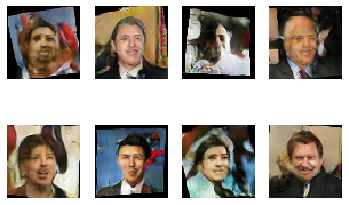

In [24]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

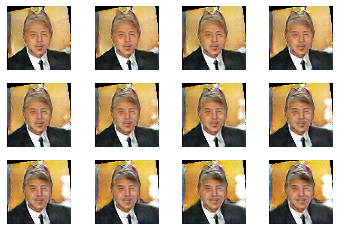

In [25]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

In [95]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [96]:
# define loss
def wasserstein_loss(y_true, y_pred):
    return -1*mx.ndarray.mean(y_true * y_pred)

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# define trainer (optimizer) for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(),optimizer  =  RMSProp(learning_rate=lr))
# implementing clip weights
trainerD = gluon.Trainer(netD.collect_params(),optimizer  = RMSProp(learning_rate=lr,clip_weights = 0.01))



INFO:root:speed: 67.9780655349628 samples/s
INFO:root:discriminator loss = -0.027659, generator loss = 0.009999, binary training acc = 0.082812 at iter 0 epoch 0
INFO:root:speed: 227.65050256285005 samples/s
INFO:root:discriminator loss = -0.189390, generator loss = 0.095149, binary training acc = 0.007528 at iter 10 epoch 0
INFO:root:speed: 240.99785069802937 samples/s
INFO:root:discriminator loss = -0.518432, generator loss = 0.268663, binary training acc = 0.003943 at iter 20 epoch 0
INFO:root:speed: 227.541281759601 samples/s
INFO:root:discriminator loss = -0.725497, generator loss = 0.383451, binary training acc = 0.003377 at iter 30 epoch 0
INFO:root:speed: 233.6305747562608 samples/s
INFO:root:discriminator loss = -0.862440, generator loss = 0.446634, binary training acc = 0.026829 at iter 40 epoch 0
INFO:root:speed: 227.6120896591781 samples/s
INFO:root:discriminator loss = -0.972045, generator loss = 0.493018, binary training acc = 0.054902 at iter 50 epoch 0
INFO:root:speed: 

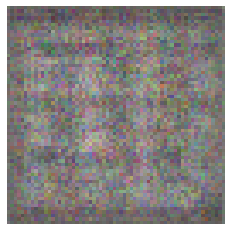

INFO:root:speed: 265.84242894804083 samples/s
INFO:root:discriminator loss = -1.432505, generator loss = 0.703143, binary training acc = 0.500000 at iter 0 epoch 1
INFO:root:speed: 217.46405593045958 samples/s
INFO:root:discriminator loss = -1.433166, generator loss = 0.710176, binary training acc = 0.500000 at iter 10 epoch 1
INFO:root:speed: 224.44492419295366 samples/s
INFO:root:discriminator loss = -1.444700, generator loss = 0.709181, binary training acc = 0.500000 at iter 20 epoch 1
INFO:root:speed: 224.3922031501039 samples/s
INFO:root:discriminator loss = -1.455022, generator loss = 0.706965, binary training acc = 0.500000 at iter 30 epoch 1
INFO:root:speed: 227.58468737097255 samples/s
INFO:root:discriminator loss = -1.443710, generator loss = 0.712857, binary training acc = 0.500000 at iter 40 epoch 1
INFO:root:speed: 218.00093880700044 samples/s
INFO:root:discriminator loss = -1.450346, generator loss = 0.714824, binary training acc = 0.500000 at iter 50 epoch 1
INFO:root:sp

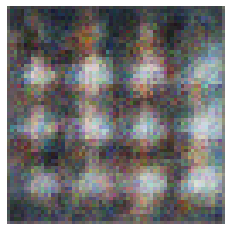

INFO:root:speed: 275.27239651217286 samples/s
INFO:root:discriminator loss = -1.377371, generator loss = 0.719391, binary training acc = 0.492188 at iter 0 epoch 2
INFO:root:speed: 227.55729167991225 samples/s
INFO:root:discriminator loss = -1.466803, generator loss = 0.722890, binary training acc = 0.485938 at iter 10 epoch 2
INFO:root:speed: 227.58333672458932 samples/s
INFO:root:discriminator loss = -1.435709, generator loss = 0.720517, binary training acc = 0.482664 at iter 20 epoch 2
INFO:root:speed: 222.41805093396613 samples/s
INFO:root:discriminator loss = -1.333318, generator loss = 0.730500, binary training acc = 0.483266 at iter 30 epoch 2
INFO:root:speed: 227.60919473956434 samples/s
INFO:root:discriminator loss = -1.431765, generator loss = 0.708833, binary training acc = 0.475877 at iter 40 epoch 2
INFO:root:speed: 227.61112467779134 samples/s
INFO:root:discriminator loss = -1.439271, generator loss = 0.713726, binary training acc = 0.477114 at iter 50 epoch 2
INFO:root:s

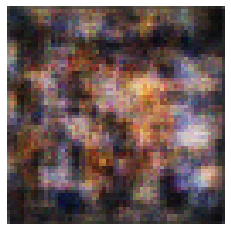

INFO:root:speed: 263.77430033871457 samples/s
INFO:root:discriminator loss = -1.370672, generator loss = 0.674261, binary training acc = 0.500000 at iter 0 epoch 3
INFO:root:speed: 227.60958072459147 samples/s
INFO:root:discriminator loss = -1.187156, generator loss = 0.662934, binary training acc = 0.478267 at iter 10 epoch 3
INFO:root:speed: 227.6090017475417 samples/s
INFO:root:discriminator loss = -1.430829, generator loss = 0.706577, binary training acc = 0.476190 at iter 20 epoch 3
INFO:root:speed: 227.6090017475417 samples/s
INFO:root:discriminator loss = -1.379522, generator loss = 0.666143, binary training acc = 0.478175 at iter 30 epoch 3
INFO:root:speed: 227.5831437764147 samples/s
INFO:root:discriminator loss = -1.406539, generator loss = 0.698813, binary training acc = 0.467797 at iter 40 epoch 3
INFO:root:speed: 226.03073409868256 samples/s
INFO:root:discriminator loss = -1.353213, generator loss = 0.680507, binary training acc = 0.464828 at iter 50 epoch 3
INFO:root:spee

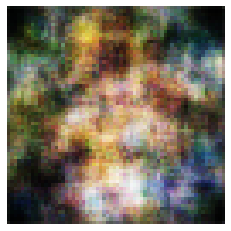

INFO:root:speed: 271.77447722721354 samples/s
INFO:root:discriminator loss = -1.239478, generator loss = 0.569018, binary training acc = 0.435937 at iter 0 epoch 4
INFO:root:speed: 215.62968645447674 samples/s
INFO:root:discriminator loss = -1.360140, generator loss = 0.688017, binary training acc = 0.416051 at iter 10 epoch 4
INFO:root:speed: 227.55709877589774 samples/s
INFO:root:discriminator loss = -1.403630, generator loss = 0.692197, binary training acc = 0.418973 at iter 20 epoch 4
INFO:root:speed: 232.16822534987125 samples/s
INFO:root:discriminator loss = -1.372132, generator loss = 0.692646, binary training acc = 0.428125 at iter 30 epoch 4
INFO:root:speed: 227.5817931483529 samples/s
INFO:root:discriminator loss = -1.314206, generator loss = 0.647128, binary training acc = 0.432012 at iter 40 epoch 4
INFO:root:speed: 227.6090017475417 samples/s
INFO:root:discriminator loss = -1.372098, generator loss = 0.667318, binary training acc = 0.430576 at iter 50 epoch 4
INFO:root:spe

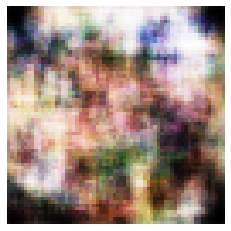

INFO:root:speed: 275.7958968963703 samples/s
INFO:root:discriminator loss = -1.002563, generator loss = 0.517777, binary training acc = 0.270313 at iter 0 epoch 5
INFO:root:speed: 227.60880875584633 samples/s
INFO:root:discriminator loss = -0.456342, generator loss = 0.589995, binary training acc = 0.439347 at iter 10 epoch 5
INFO:root:speed: 225.95443966239256 samples/s
INFO:root:discriminator loss = -1.360269, generator loss = 0.659867, binary training acc = 0.446949 at iter 20 epoch 5
INFO:root:speed: 227.6090017475417 samples/s
INFO:root:discriminator loss = -1.421384, generator loss = 0.700673, binary training acc = 0.450353 at iter 30 epoch 5
INFO:root:speed: 227.77644878591843 samples/s
INFO:root:discriminator loss = -1.375927, generator loss = 0.662502, binary training acc = 0.458498 at iter 40 epoch 5
INFO:root:speed: 230.65051868031026 samples/s
INFO:root:discriminator loss = -1.391600, generator loss = 0.668594, binary training acc = 0.456219 at iter 50 epoch 5
INFO:root:spe

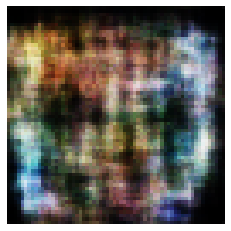

INFO:root:speed: 285.65806648654 samples/s
INFO:root:discriminator loss = -1.441848, generator loss = 0.712729, binary training acc = 0.435937 at iter 0 epoch 6
INFO:root:speed: 233.6645372112113 samples/s
INFO:root:discriminator loss = -1.302824, generator loss = 0.595470, binary training acc = 0.468608 at iter 10 epoch 6
INFO:root:speed: 230.85443213784765 samples/s
INFO:root:discriminator loss = -1.439973, generator loss = 0.687792, binary training acc = 0.472693 at iter 20 epoch 6
INFO:root:speed: 226.753224724663 samples/s
INFO:root:discriminator loss = -1.413162, generator loss = 0.709195, binary training acc = 0.458972 at iter 30 epoch 6
INFO:root:speed: 233.9027549652024 samples/s
INFO:root:discriminator loss = -1.446852, generator loss = 0.703514, binary training acc = 0.466120 at iter 40 epoch 6
INFO:root:speed: 225.68069894606575 samples/s
INFO:root:discriminator loss = -1.069530, generator loss = 0.053011, binary training acc = 0.466299 at iter 50 epoch 6
INFO:root:speed: 2

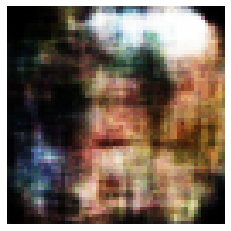

INFO:root:speed: 271.9509661392825 samples/s
INFO:root:discriminator loss = -0.781999, generator loss = 0.712086, binary training acc = 0.390625 at iter 0 epoch 7
INFO:root:speed: 233.77116616722532 samples/s
INFO:root:discriminator loss = -0.833178, generator loss = 0.728856, binary training acc = 0.468040 at iter 10 epoch 7
INFO:root:speed: 227.60707184531546 samples/s
INFO:root:discriminator loss = -0.971716, generator loss = 0.575597, binary training acc = 0.463765 at iter 20 epoch 7
INFO:root:speed: 226.753224724663 samples/s
INFO:root:discriminator loss = -1.455037, generator loss = 0.715531, binary training acc = 0.466129 at iter 30 epoch 7
INFO:root:speed: 227.60958072459147 samples/s
INFO:root:discriminator loss = -1.470236, generator loss = 0.726150, binary training acc = 0.464329 at iter 40 epoch 7
INFO:root:speed: 227.5852662243301 samples/s
INFO:root:discriminator loss = -1.433220, generator loss = 0.710283, binary training acc = 0.466115 at iter 50 epoch 7
INFO:root:speed

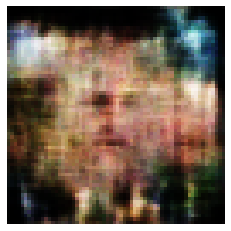

INFO:root:speed: 278.6536866909574 samples/s
INFO:root:discriminator loss = -1.434656, generator loss = 0.710167, binary training acc = 0.498437 at iter 0 epoch 8
INFO:root:speed: 227.62367007406968 samples/s
INFO:root:discriminator loss = -0.111797, generator loss = -0.452514, binary training acc = 0.481534 at iter 10 epoch 8
INFO:root:speed: 227.6090017475417 samples/s
INFO:root:discriminator loss = -1.303788, generator loss = 0.728629, binary training acc = 0.481622 at iter 20 epoch 8
INFO:root:speed: 227.60977371759597 samples/s
INFO:root:discriminator loss = -1.442996, generator loss = 0.711958, binary training acc = 0.476815 at iter 30 epoch 8
INFO:root:speed: 227.60861576447823 samples/s
INFO:root:discriminator loss = -1.449031, generator loss = 0.713550, binary training acc = 0.478087 at iter 40 epoch 8
INFO:root:speed: 222.58809559741752 samples/s
INFO:root:discriminator loss = -1.400640, generator loss = 0.696953, binary training acc = 0.479994 at iter 50 epoch 8
INFO:root:sp

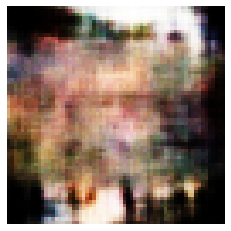

INFO:root:speed: 276.4434704520551 samples/s
INFO:root:discriminator loss = -1.436847, generator loss = 0.706757, binary training acc = 0.500000 at iter 0 epoch 9
INFO:root:speed: 227.61151066936418 samples/s
INFO:root:discriminator loss = -1.268648, generator loss = 0.690452, binary training acc = 0.469886 at iter 10 epoch 9
INFO:root:speed: 227.60861576447823 samples/s
INFO:root:discriminator loss = -1.416227, generator loss = 0.684092, binary training acc = 0.472098 at iter 20 epoch 9
INFO:root:speed: 223.26512558667972 samples/s
INFO:root:discriminator loss = -1.394212, generator loss = 0.699049, binary training acc = 0.466381 at iter 30 epoch 9
INFO:root:speed: 227.60880875584633 samples/s
INFO:root:discriminator loss = -1.452320, generator loss = 0.713637, binary training acc = 0.468674 at iter 40 epoch 9
INFO:root:speed: 227.60880875584633 samples/s
INFO:root:discriminator loss = -1.452100, generator loss = 0.711097, binary training acc = 0.472365 at iter 50 epoch 9
INFO:root:sp

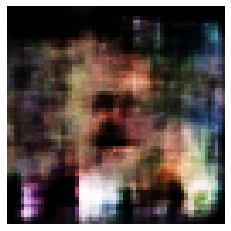

INFO:root:speed: 273.5932356790209 samples/s
INFO:root:discriminator loss = -1.080814, generator loss = -0.376021, binary training acc = 0.390625 at iter 0 epoch 10
INFO:root:speed: 224.58801490920195 samples/s
INFO:root:discriminator loss = -0.455434, generator loss = 0.146082, binary training acc = 0.460795 at iter 10 epoch 10
INFO:root:speed: 227.60880875584633 samples/s
INFO:root:discriminator loss = -0.873805, generator loss = 0.717489, binary training acc = 0.464360 at iter 20 epoch 10
INFO:root:speed: 227.60958072459147 samples/s
INFO:root:discriminator loss = -1.454251, generator loss = 0.718230, binary training acc = 0.459627 at iter 30 epoch 10
INFO:root:speed: 227.60687885689285 samples/s
INFO:root:discriminator loss = -1.442368, generator loss = 0.707178, binary training acc = 0.462767 at iter 40 epoch 10
INFO:root:speed: 227.55709877589774 samples/s
INFO:root:discriminator loss = -1.448107, generator loss = 0.708310, binary training acc = 0.465472 at iter 50 epoch 10
INFO:

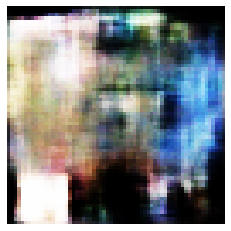

INFO:root:speed: 293.900783266948 samples/s
INFO:root:discriminator loss = -1.406363, generator loss = 0.673657, binary training acc = 0.498437 at iter 0 epoch 11
INFO:root:speed: 225.9321888961085 samples/s
INFO:root:discriminator loss = -0.974489, generator loss = 0.139352, binary training acc = 0.458949 at iter 10 epoch 11
INFO:root:speed: 226.75265009608682 samples/s
INFO:root:discriminator loss = -1.056391, generator loss = 0.539327, binary training acc = 0.452381 at iter 20 epoch 11
INFO:root:speed: 215.65324581945845 samples/s
INFO:root:discriminator loss = -1.438577, generator loss = 0.709404, binary training acc = 0.458266 at iter 30 epoch 11
INFO:root:speed: 220.59157080062354 samples/s
INFO:root:discriminator loss = -1.451867, generator loss = 0.709359, binary training acc = 0.459489 at iter 40 epoch 11
INFO:root:speed: 227.60919473956434 samples/s
INFO:root:discriminator loss = -1.404620, generator loss = 0.691533, binary training acc = 0.460938 at iter 50 epoch 11
INFO:roo

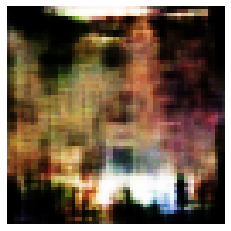

INFO:root:speed: 281.6676383126518 samples/s
INFO:root:discriminator loss = -1.419820, generator loss = 0.697704, binary training acc = 0.495312 at iter 0 epoch 12
INFO:root:speed: 227.60726483406535 samples/s
INFO:root:discriminator loss = -1.049866, generator loss = 0.725508, binary training acc = 0.481250 at iter 10 epoch 12
INFO:root:speed: 225.41575988834828 samples/s
INFO:root:discriminator loss = -1.389415, generator loss = 0.642462, binary training acc = 0.468304 at iter 20 epoch 12
INFO:root:speed: 232.01792283225004 samples/s
INFO:root:discriminator loss = -1.428819, generator loss = 0.710180, binary training acc = 0.467893 at iter 30 epoch 12
INFO:root:speed: 227.60938773191427 samples/s
INFO:root:discriminator loss = -1.413948, generator loss = 0.691516, binary training acc = 0.468750 at iter 40 epoch 12
INFO:root:speed: 227.6254072379389 samples/s
INFO:root:discriminator loss = -1.406253, generator loss = 0.685450, binary training acc = 0.469026 at iter 50 epoch 12
INFO:ro

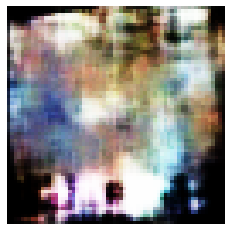

INFO:root:speed: 269.26019999257727 samples/s
INFO:root:discriminator loss = -1.303931, generator loss = 0.714745, binary training acc = 0.317188 at iter 0 epoch 13
INFO:root:speed: 227.60996671092772 samples/s
INFO:root:discriminator loss = -0.429286, generator loss = 0.587997, binary training acc = 0.450852 at iter 10 epoch 13
INFO:root:speed: 227.58391557107623 samples/s
INFO:root:discriminator loss = -1.449335, generator loss = 0.701941, binary training acc = 0.458408 at iter 20 epoch 13
INFO:root:speed: 227.55729167991225 samples/s
INFO:root:discriminator loss = -1.407737, generator loss = 0.694434, binary training acc = 0.462399 at iter 30 epoch 13
INFO:root:speed: 227.60861576447823 samples/s
INFO:root:discriminator loss = -1.420485, generator loss = 0.700598, binary training acc = 0.460480 at iter 40 epoch 13
INFO:root:speed: 216.66209777724686 samples/s
INFO:root:discriminator loss = -1.410854, generator loss = 0.694132, binary training acc = 0.460692 at iter 50 epoch 13
INFO:

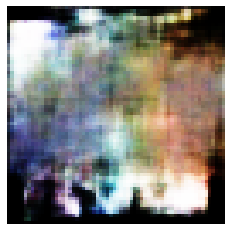

INFO:root:speed: 276.63462979241746 samples/s
INFO:root:discriminator loss = -1.054143, generator loss = 0.720525, binary training acc = 0.339062 at iter 0 epoch 14
INFO:root:speed: 227.60919473956434 samples/s
INFO:root:discriminator loss = -1.270526, generator loss = 0.647216, binary training acc = 0.452841 at iter 10 epoch 14
INFO:root:speed: 227.60958072459147 samples/s
INFO:root:discriminator loss = -1.345004, generator loss = 0.715594, binary training acc = 0.444345 at iter 20 epoch 14
INFO:root:speed: 227.61073868752766 samples/s
INFO:root:discriminator loss = -1.448834, generator loss = 0.715055, binary training acc = 0.451915 at iter 30 epoch 14
INFO:root:speed: 218.85781420577908 samples/s
INFO:root:discriminator loss = -1.401750, generator loss = 0.680736, binary training acc = 0.457431 at iter 40 epoch 14
INFO:root:speed: 227.6113176734141 samples/s
INFO:root:discriminator loss = -1.099448, generator loss = 0.710873, binary training acc = 0.456771 at iter 50 epoch 14
INFO:r

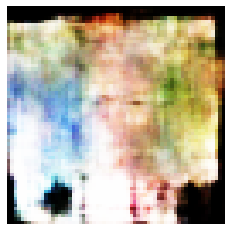

INFO:root:speed: 286.9255096958179 samples/s
INFO:root:discriminator loss = -1.311136, generator loss = 0.584163, binary training acc = 0.481250 at iter 0 epoch 15
INFO:root:speed: 237.4020257870863 samples/s
INFO:root:discriminator loss = -1.359116, generator loss = 0.624323, binary training acc = 0.452983 at iter 10 epoch 15
INFO:root:speed: 227.6074578231425 samples/s
INFO:root:discriminator loss = -1.420942, generator loss = 0.680395, binary training acc = 0.441741 at iter 20 epoch 15
INFO:root:speed: 225.95386907517613 samples/s
INFO:root:discriminator loss = -1.393462, generator loss = 0.693617, binary training acc = 0.441230 at iter 30 epoch 15
INFO:root:speed: 225.1620180709754 samples/s
INFO:root:discriminator loss = -1.418806, generator loss = 0.684601, binary training acc = 0.444970 at iter 40 epoch 15
INFO:root:speed: 223.9248032366374 samples/s
INFO:root:discriminator loss = -1.448444, generator loss = 0.715120, binary training acc = 0.446446 at iter 50 epoch 15
INFO:root:

KeyboardInterrupt: 

In [97]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = -1 * nd.ones((batch_size,), ctx=ctx)
def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network:
        ###########################
        
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
        for iteration in range(5):
            with autograd.record():
                # train with real image
                output = netD(data) 
                errD_real = wasserstein_loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = netG(latent_z)
                output = netD(fake.detach())
                errD_fake = wasserstein_loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: 
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake)
            errG = wasserstein_loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                      nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

    #Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

In [ ]:
# Your code here...